In [1]:
# change to correct working directory
# %pwd
%cd ..
%pwd

/home/felix/bluebird/energy-aware-computing


'/home/felix/bluebird/energy-aware-computing'

In [2]:
# load the auto-reload extension
%load_ext autoreload
%autoreload 2

In [3]:
import hvplot
import hvplot.pandas
import holoviews as hv
from bokeh.models import HoverTool
from gpyjoules.util import TimestampInfo
from gpyjoules.new_analysis import *
import bokeh.themes
from pathlib import Path
import pandas as pd
import json
import numpy as np
import holoviews as hv
from holoviews import opts
import seaborn as sns
import statsmodels.formula.api as sm

In [4]:
def mse(df, column):
    return ((df[column] - df[f"{column}_hat"]) ** 2).mean()


def rmse(df, column):
    return np.sqrt(mse(df, column))

In [5]:
v100 = DataLoader("data/t4-3")
v100_pl = v100.experiments["power-limit"]

In [43]:
util = "util_gpu_norm"
#util = "p_util"

In [6]:
#p_max_nominal = 175#
#f_max = 875#

In [7]:
p_max_nominal = 300#70#175#
f_max = 1530#1575#875#

In [6]:
p_max_nominal = 70#175#
f_max = 1575#875#

In [7]:
p_baseline = v100_pl.baseline_hd.as_baseline() / 1_000
p_max = p_max_nominal - p_baseline
p_baseline,p_max

(9.32877966101695, 60.67122033898305)

In [8]:
v100_pl.baseline_hd.as_baseline()/1_000, v100_pl.baseline_sd.as_baseline()/1_000

(9.32877966101695, 9.320860139860141)

In [9]:
v100_pl.baseline_hd.data["power"].std()/1_000, v100_pl.baseline_sd.data["power"].std()/1_000

(0.33841542859516327, 0.2761067325128595)

In [10]:
def get_all_agg(exp):
    all_agg = []
    for bench in exp.benchmarks.values():
        print(bench.name)
        tmp = bench.aggregate("sd", None)#"mean")
        tmp["benchmark"] = bench.name
        all_agg.append(tmp)
    all_agg = pd.concat(all_agg)
    return all_agg

In [11]:
def plot_model(x,y,data,hue:str="benchmark"):
    sns.scatterplot(x=x,y=y,hue="benchmark", data=data)
    sns.lineplot(x=x,y=f"{y}_hat", data=data,hue=hue)#, style=list("xxxxxxxxxxxxxxx"), markers={"x":"x"}) ,hue="benchmark"

In [12]:
all_agg = get_all_agg(v100_pl)
#all_agg = all_agg[all_agg["benchmark"] != "nbody"]

mnist-dense
resnet
mnist-cnn
nbody
bert


In [13]:
all_agg = all_agg.rename(columns={"clock-gpu": "clock_gpu",
                                 "enforced-power-limit": "enforced_power_limit"})

In [14]:
all_agg["enforced_power_limit"] = all_agg["enforced_power_limit"] / 1_000

In [15]:
def get_activity_from_power(power, p_max, p_max_nominal):
    return power.loc[f"{p_max_nominal}W"].mean() / p_max

In [16]:
all_agg = all_agg[all_agg.index != "2505MHz,562MHz"]
all_agg = all_agg[all_agg.index != "100W"]
all_agg = all_agg.copy()

In [17]:
all_agg

timestamp  clock-mem    clock_gpu  app-clock-mem  app-clock-gpu  \
run                                                                    
60W  25.882205     5000.0  1047.398844         5001.0          585.0   
60W  26.197553     5000.0   982.542857         5001.0          585.0   
60W  26.577758     5000.0   966.741573         5001.0          585.0   
60W  26.356797     5000.0   976.789773         5001.0          585.0   
60W  26.482638     5000.0   964.237288         5001.0          585.0   
..         ...        ...          ...            ...            ...   
70W   7.454594     5000.0  1036.800000         5001.0          585.0   
70W   7.417646     5000.0  1036.200000         5001.0          585.0   
70W   7.357745     5000.0  1039.800000         5001.0          585.0   
70W   7.453483     5000.0  1036.500000         5001.0          585.0   
70W   7.418011     5000.0  1051.200000         5001.0          585.0   

     enforced_power_limit  total-energy  power-state      power        tmp  \
run                                                                          
60W                  60.0  2.916056e+10          0.0  50.949342  59.815029   
60W                  60.0  2.919741e+10          0.0  51.719923  66.451429   
60W                  60.0  2.924396e+10          0.0  51.272353  69.865169   
60W                  60.0  2.928099e+10          0.0  51.056236  68.352273   
60W                  60.0  2.932440e+10          0.0  50.904383  69.463277   
..                    ...           ...          ...        ...        ...   
70W                  70.0  2.938167e+10          0.0  61.119400  67.600000   
70W                  70.0  2.941965e+10          0.0  60.143540  68.620000   
70W                  70.0  2.946214e+10          0.0  60.356380  67.200000   
70W                  70.0  2.950011e+10          0.0  60.785760  68.540000   
70W                  70.0  2.954287e+10          0.0  60.944340  67.200000   

           pci-tx        pci-rx   util-gpu   util-mem    energy        edp  \
run                                                                          
60W  10109.826590  52439.306358  85.849711  67.046243  1.315671  34.052467   
60W  10034.285714  51377.142857  87.062857  66.200000  1.350589  35.382117   
60W   9915.730337  51685.393258  86.522472  65.067416  1.362100  36.201569   
60W   9857.954545  51517.045455  86.818182  65.448864  1.341039  35.345496   
60W   9559.322034  52141.242938  87.163842  65.378531  1.344668  35.610361   
..            ...           ...        ...        ...       ...        ...   
70W  29560.000000  26620.000000  96.900000  68.040000  0.449754   3.352737   
70W  37500.000000  26520.000000  96.460000  68.240000  0.444170   3.294699   
70W  32980.000000  58080.000000  96.620000  68.420000  0.445654   3.279010   
70W  28780.000000  37840.000000  95.960000  67.720000  0.447938   3.338697   
70W  29540.000000  26140.000000  96.060000  67.720000  0.448205   3.324790   

           ed2p    benchmark  
run                           
60W  881.352925  mnist-dense  
60W  926.924895  mnist-dense  
60W  962.156538  mnist-dense  
60W  931.594062  mnist-dense  
60W  943.056294  mnist-dense  
..          ...          ...  
70W   24.993293         bert  
70W   24.438913         bert  
70W   24.126123         bert  
70W   24.884922         bert  
70W   24.663331         bert  

[150 rows x 18 columns]

In [190]:
#all_agg["energy"] =  all_agg["energy"] + (p_baseline *  all_agg["timestamp"])/1_000

In [18]:
all_agg["total_power"] = all_agg["power"] + p_baseline
all_agg["p_util"] = all_agg.groupby("benchmark")["power"].transform(lambda power: get_activity_from_power(power=power, p_max=p_max, p_max_nominal=p_max_nominal))
all_agg["util_gpu_norm"] = all_agg["util-gpu"] / 100

all_agg["time_reference"] = all_agg.groupby("benchmark")["timestamp"].transform(lambda time: time.loc[f"{p_max_nominal}W"].mean())
all_agg["delay"] = all_agg["timestamp"] / all_agg["time_reference"]  #all_agg.groupby("benchmark")["timestamp"].transform(lambda time: time/time.loc["300W"].mean())

# all_agg["energy_reference"] = all_agg.groupby("benchmark")["energy"].transform(lambda energy: energy.loc[f"{p_max}W"].mean())
# all_agg["relative_energy"] = all_agg["energy"] / all_agg["energy_reference"]#all_agg.groupby("benchmark")["energy"].transform(lambda energy: energy/energy.loc["300W"].mean())

all_agg["relative_clock_gpu"] = all_agg["clock_gpu"] / f_max

all_agg["relative_power"] = np.clip(all_agg["enforced_power_limit"] / all_agg["p_util"], a_max=p_max, a_min=None)

In [192]:
1505/1530

0.9836601307189542

In [193]:
all_agg.loc["300W"].groupby("benchmark")["clock_gpu"].mean()

benchmark
bert           1530.000000
mnist-cnn      1530.000000
mnist-dense    1530.000000
nbody          1505.858826
resnet         1530.000000
Name: clock_gpu, dtype: float64

In [19]:
all_agg["p_util2"] = all_agg["power"] / (all_agg["enforced_power_limit"] - p_baseline)

In [20]:
all_agg["util_combined"] = all_agg[["p_util", "util-gpu"]].mean(axis=1)

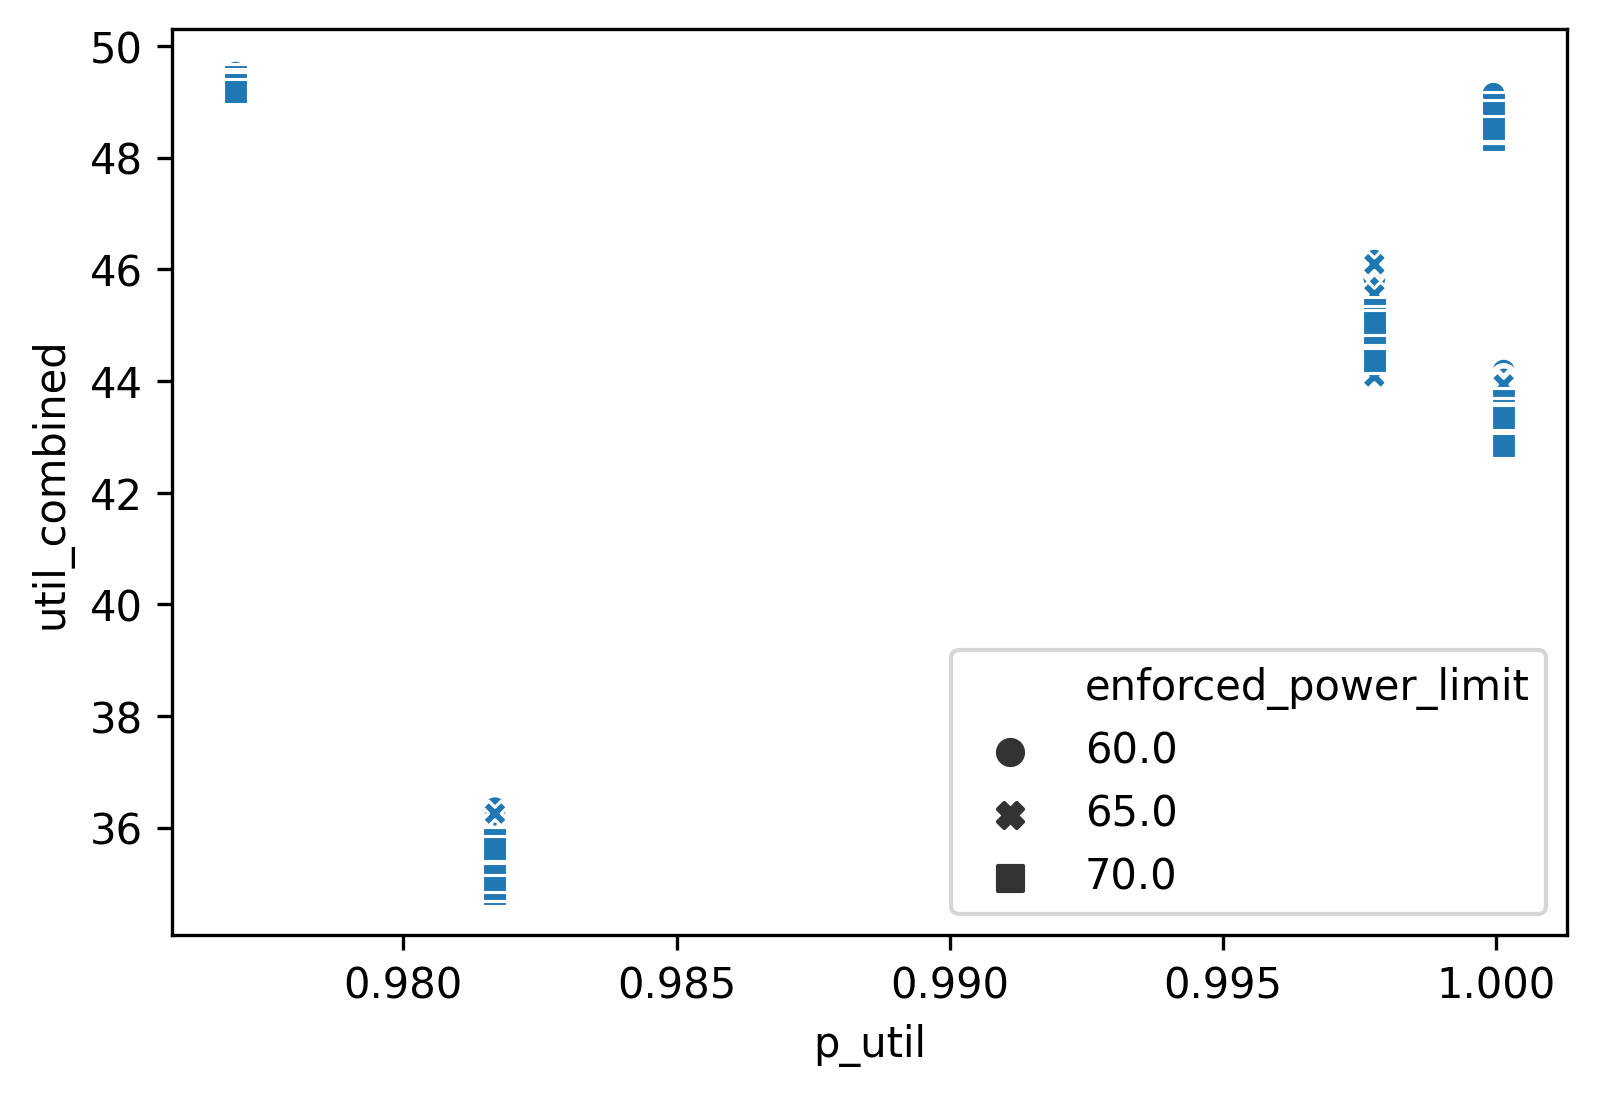

In [21]:
g = sns.scatterplot("p_util","util_combined", data=all_agg, style="enforced_power_limit")

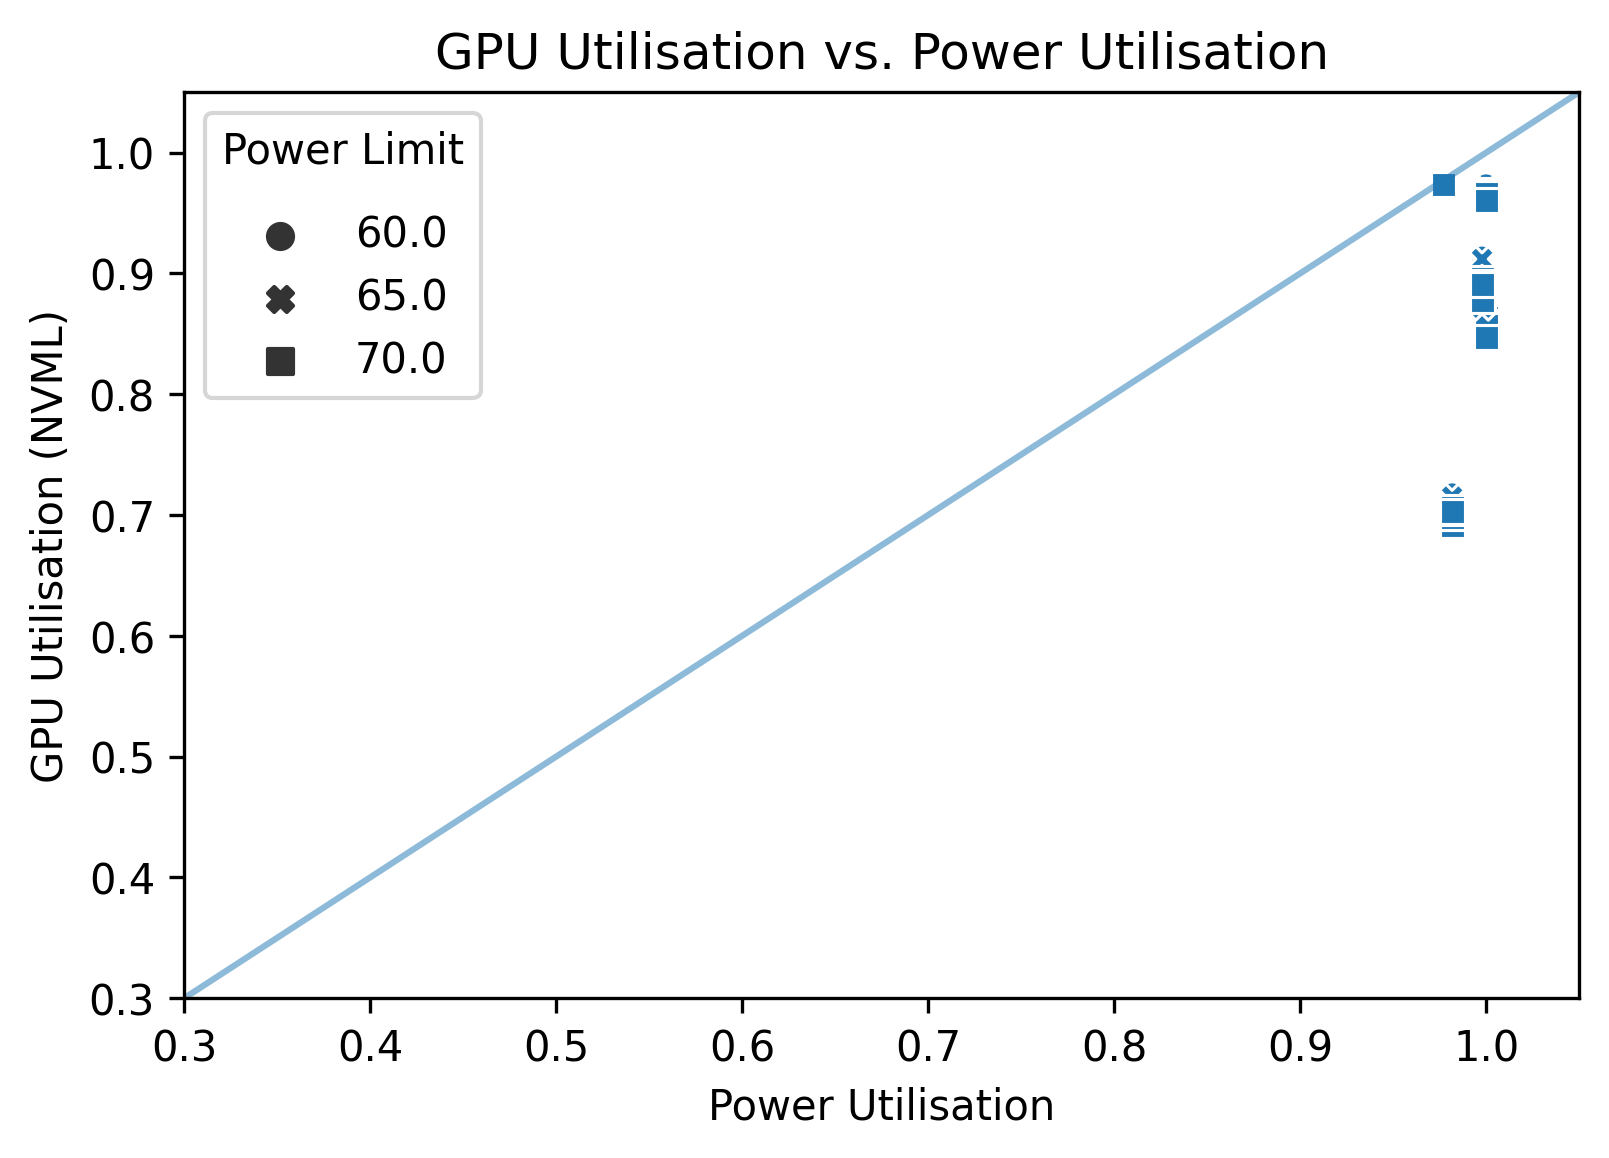

In [22]:
g = sns.scatterplot("p_util","util_gpu_norm", data=all_agg, style="enforced_power_limit")
plt.xlim((0.3,1.05))
plt.ylim((0.3,1.05))
x = np.arange(0,2,0.1)
sns.lineplot(x,x, alpha=0.5)
plt.xlabel("Power Utilisation")
plt.ylabel("GPU Utilisation (NVML)")
plt.title("GPU Utilisation vs. Power Utilisation")
g.legend_.texts[0].set_text("")
g.legend_.set_title("Power Limit")
g.legend_._legend_box.sep = -5
#plt.savefig("../master-thesis/images/util-gpu-vs-p-util.pdf")

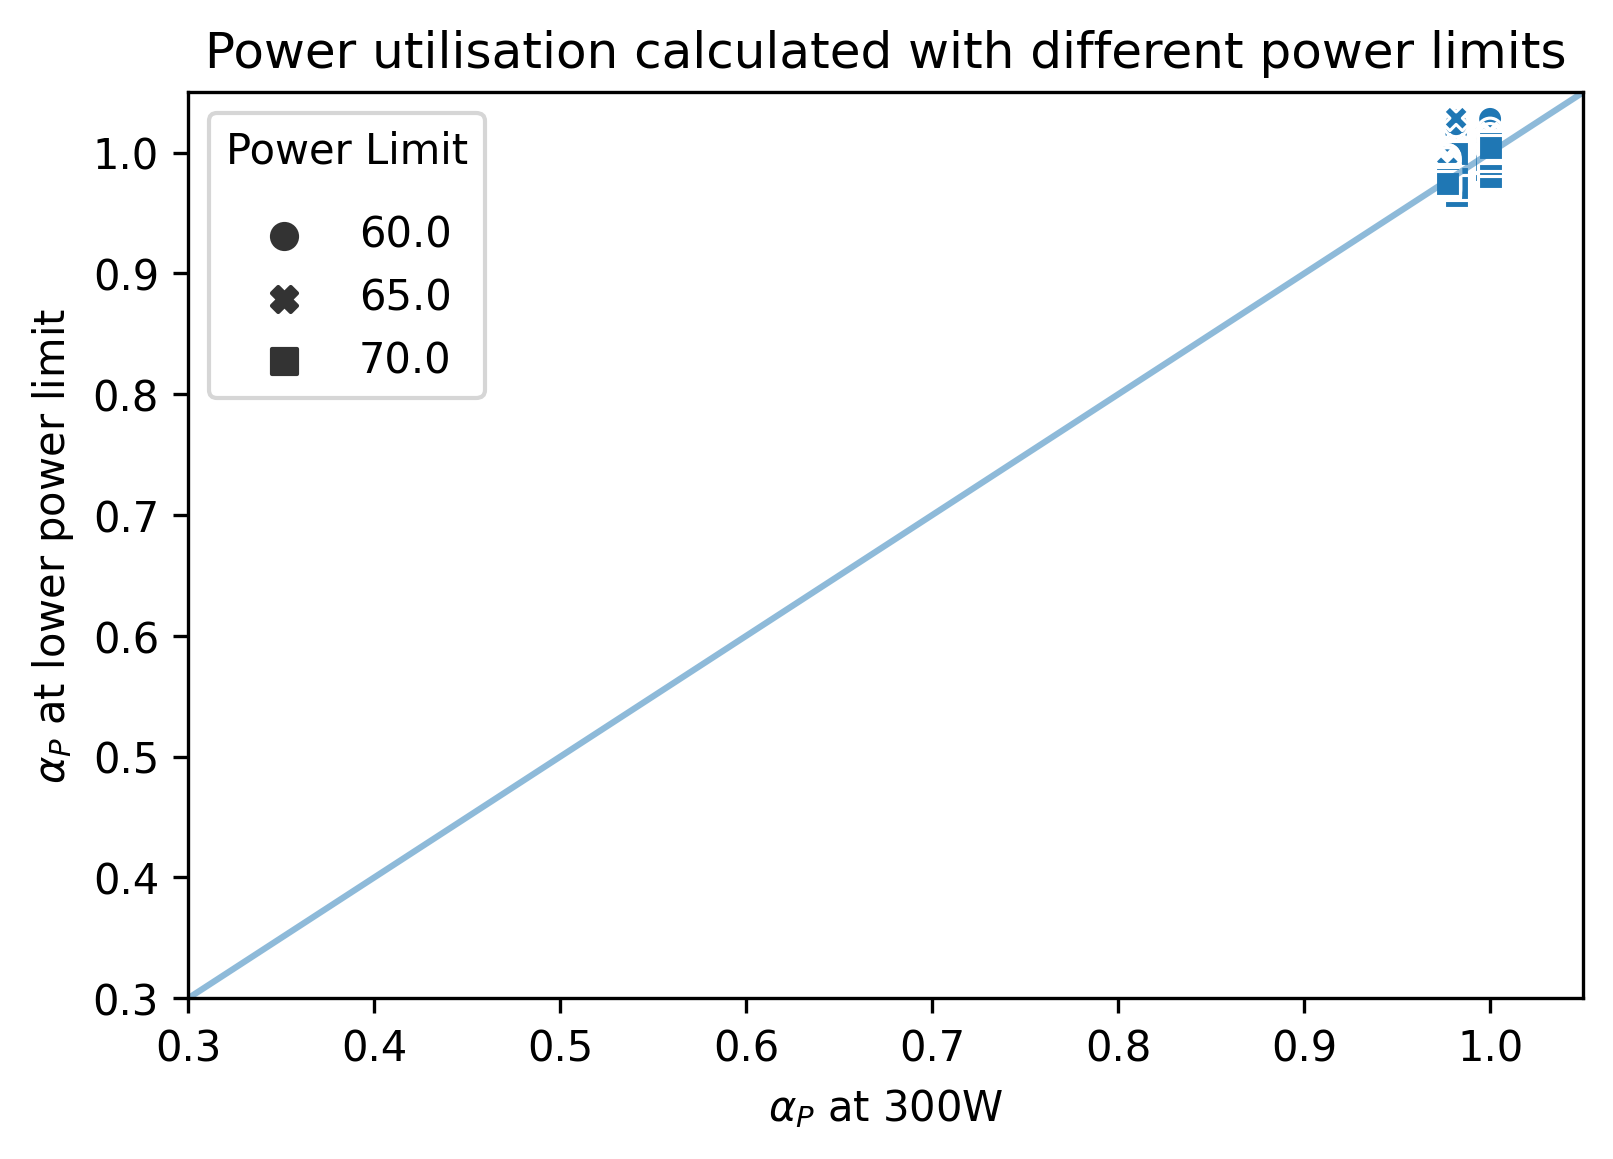

In [23]:
g = sns.scatterplot("p_util","p_util2", data=all_agg, style="enforced_power_limit")
x = np.arange(0,2,0.1)
sns.lineplot(x,x, alpha=0.5)
plt.xlabel("$\\alpha_P$ at 300W")
plt.ylabel("$\\alpha_P$ at lower power limit")
plt.xlim((0.3,1.05))
plt.ylim((0.3,1.05))
plt.title("Power utilisation calculated with different power limits")
g.legend_.texts[0].set_text("")
g.legend_.set_title("Power Limit")
g.legend_._legend_box.sep = -5 
#plt.savefig("../master-thesis/images/p-util-comparison.pdf")

In [199]:
#all_agg[(all_agg["relative_power"] > 180) & (all_agg["relative_clock_gpu"] <0.7)]

Text(0.5, 1.0, 'Clock Frequency vs. Normalised Power Limit')

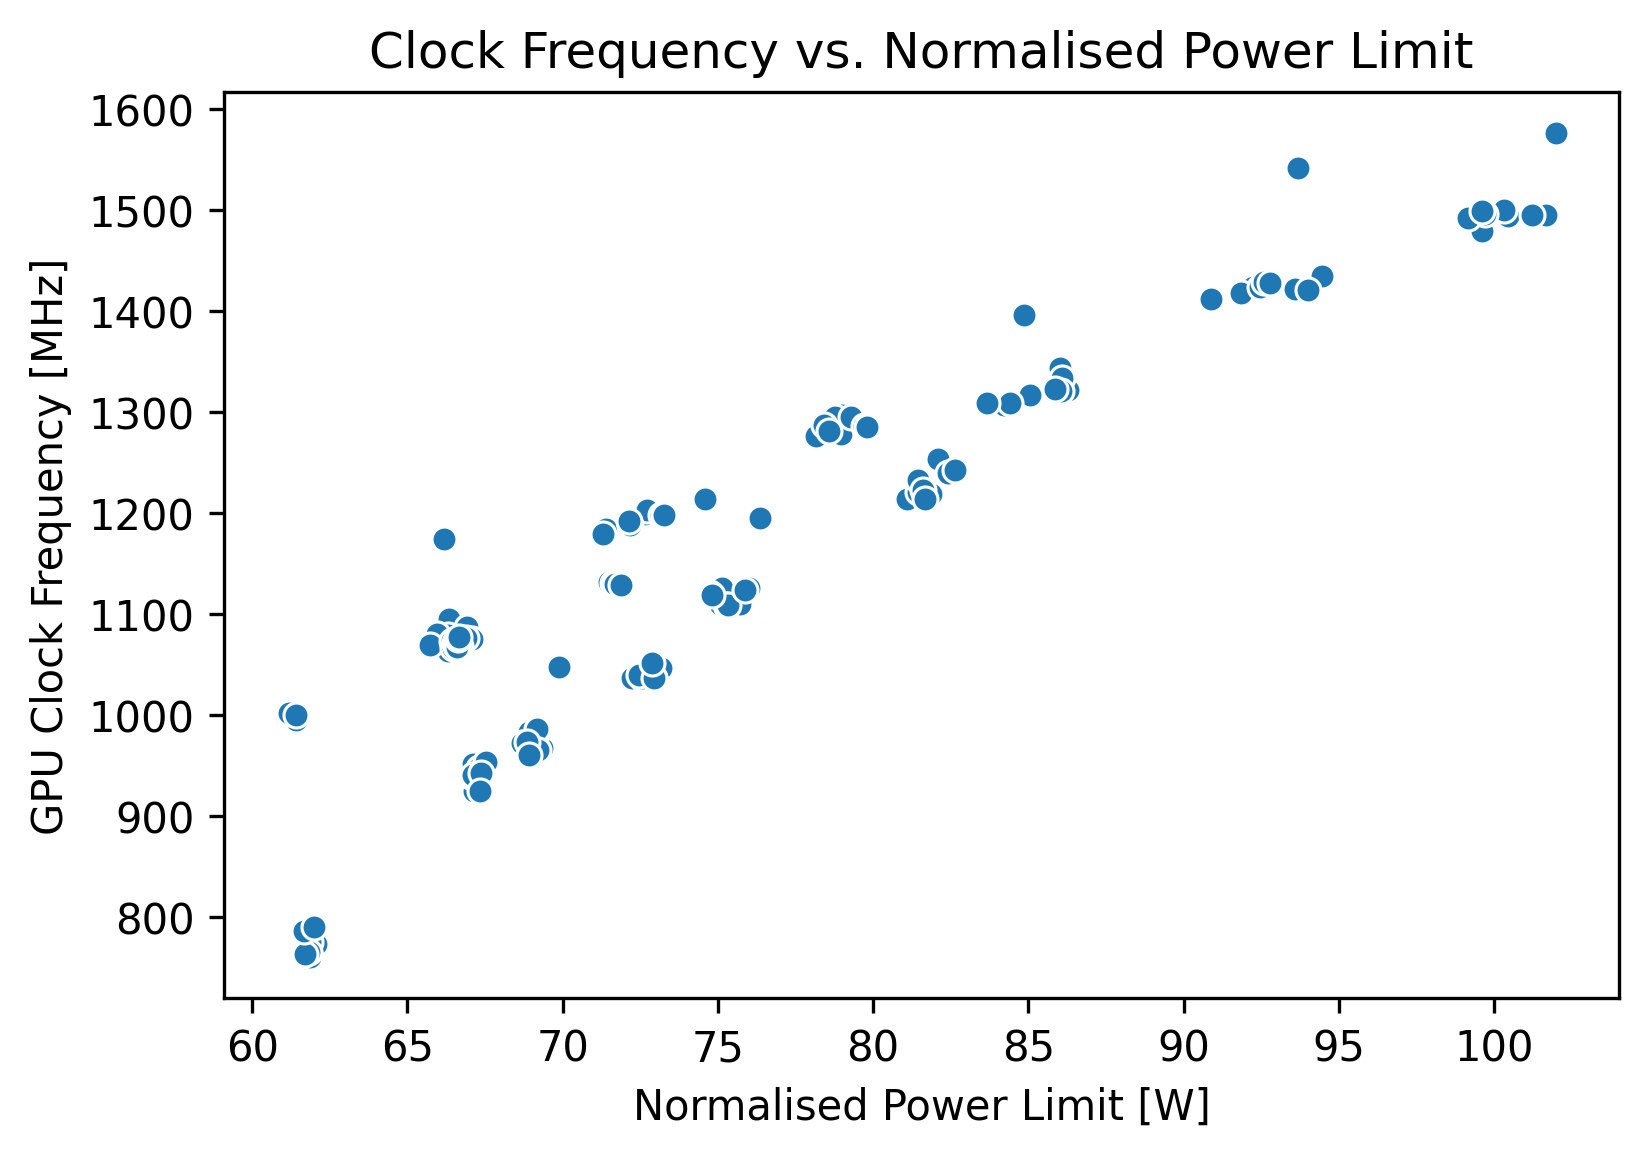

In [25]:
#all_agg["relative_power"] = all_agg["enforced_power_limit"] / all_agg["p_util"]#
all_agg["normalised_power_limit"] = all_agg["enforced_power_limit"] / all_agg[util]#np.clip(all_agg["enforced_power_limit"] / all_agg["p_util"], a_max=p_max_nominal, a_min=None)
sns.scatterplot("normalised_power_limit", "clock_gpu", data=all_agg)

plt.xlabel("Normalised Power Limit [W]")
plt.ylabel("GPU Clock Frequency [MHz]")
plt.title("Clock Frequency vs. Normalised Power Limit")
#g.legend_.set_title("Power Limit")
#g.legend_._legend_box.sep = -5 
#plt.savefig("../master-thesis/images/norm-pl-no-clip.pdf")

Text(0.5, 1.0, 'Clock Frequency vs. Normalised Power Limit (clipped at 105W)')

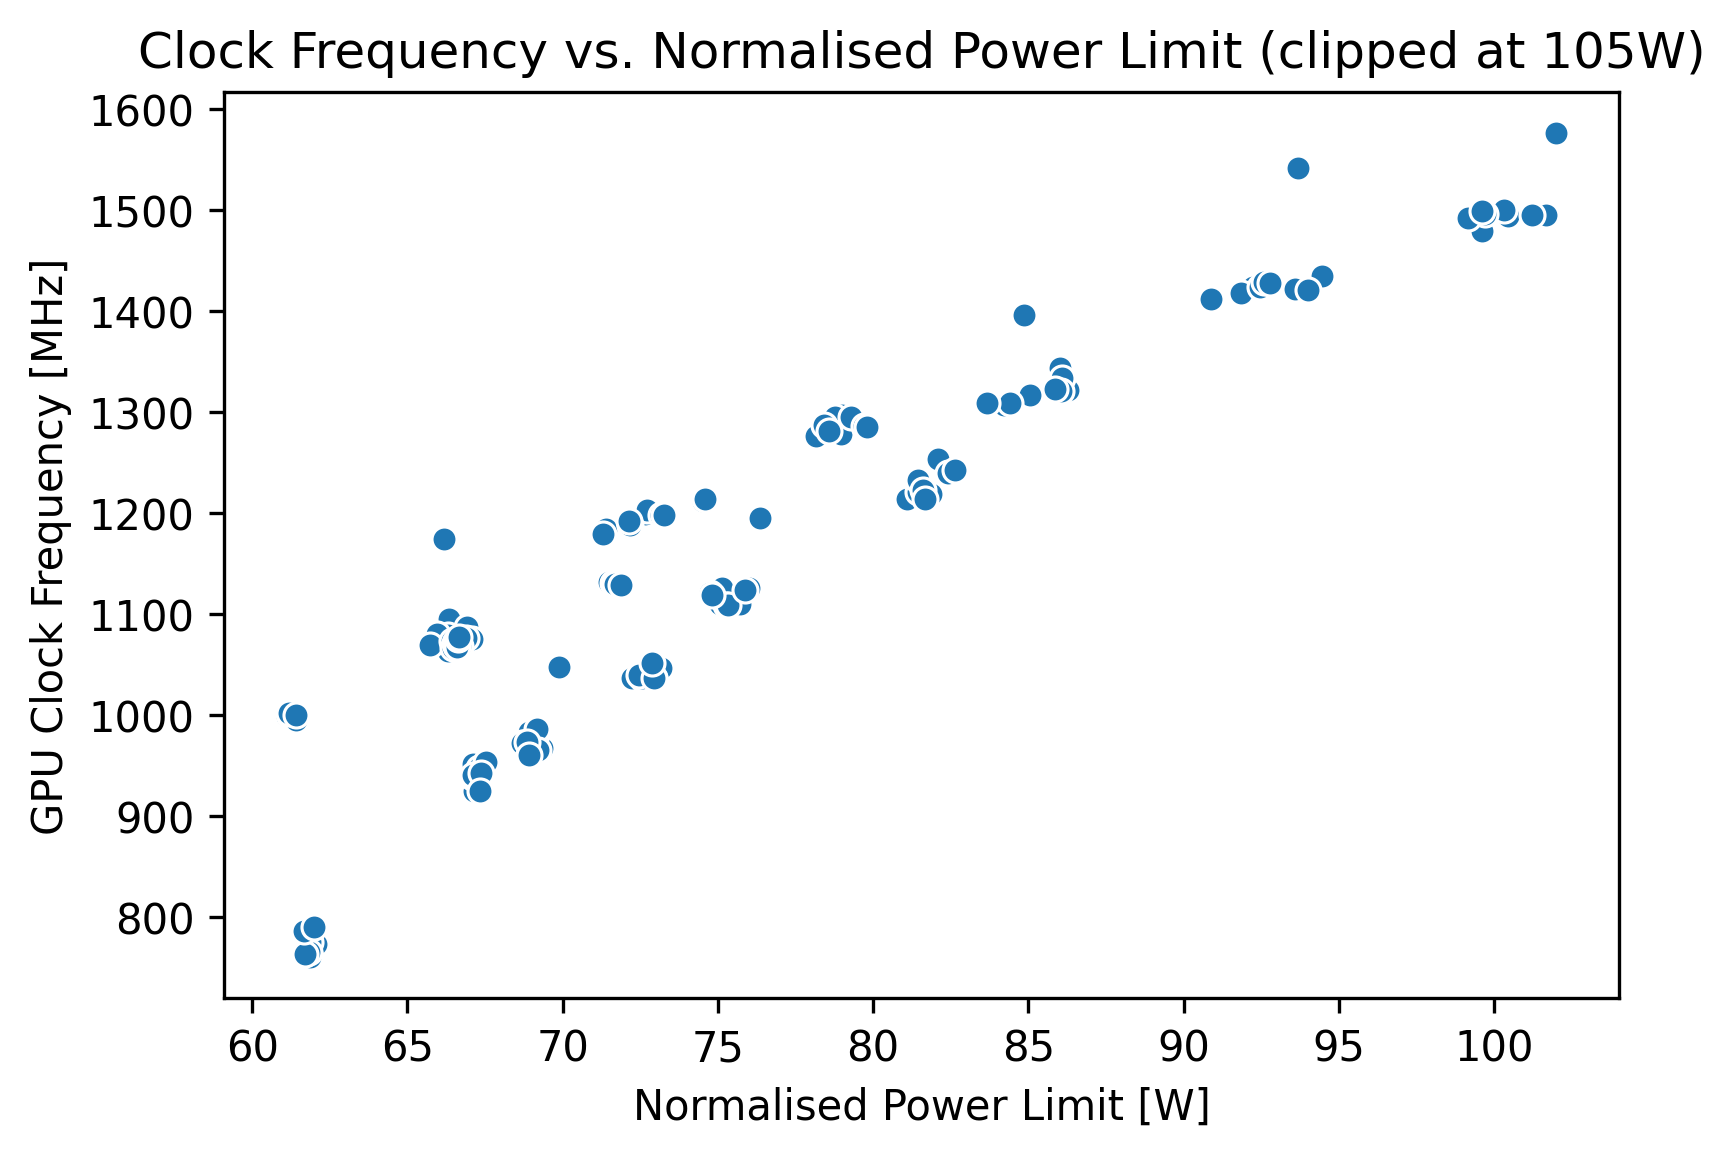

In [30]:
#all_agg["relative_power"] = all_agg["enforced_power_limit"] / all_agg["p_util"]#
a_max = p_max_nominal * 1.5
all_agg["normalised_power_limit"] = np.clip(all_agg["enforced_power_limit"] / all_agg[util], a_max=a_max, a_min=None)
sns.scatterplot("normalised_power_limit", "clock_gpu", data=all_agg)

plt.xlabel("Normalised Power Limit [W]")
plt.ylabel("GPU Clock Frequency [MHz]")
plt.title(f"Clock Frequency vs. Normalised Power Limit (clipped at {int(a_max)}W)")
#g.legend_.set_title("Power Limit")
#g.legend_._legend_box.sep = -5 
#plt.savefig("../master-thesis/images/norm-pl-clip.pdf")

In [34]:
class ClockModel():
    def __init__(self):
        self._model = None
    
    @staticmethod
    def _prepare(data):
        #data["relative_clock_gpu"] = data["clock_gpu"] / f_max
        data["relative_power"] = np.clip(data["power_limit"] / data["p_util"], a_max=a_max, a_min=None)
    
    def fit(self, power_limit, p_util, clock_gpu):
        data = pd.DataFrame({"power_limit":power_limit,
                             "clock_gpu": clock_gpu,
                             "p_util": p_util})
        self._prepare(data)#power sm.ols(formula="relative_clock_gpu ~ relative_power", data=data).fit()
        #self._model = sm.ols(formula="power ~ relative_power", data=data).fit()
        self._model = sm.ols(formula="clock_gpu ~ relative_power", data=data).fit()
    
    def predict(self, power_limit, p_util):
        data = pd.DataFrame({"power_limit": power_limit,
                             "p_util": p_util})
        self._prepare(data)
        return np.clip(self._model.predict(data) , a_max=f_max, a_min = None)#* f_max
    
    def plot(self, training_data, x = "enforced_power_limit"):
        training_data = training_data.copy()
        sns.scatterplot(x=x, y="clock_gpu",hue="benchmark", data=training_data)
        training_data["clock_gpu_hat"] = self.predict(training_data["enforced_power_limit"], training_data["p_util"])
        sns.lineplot(x=x, y="clock_gpu_hat", hue="benchmark", data=training_data)
    
    def plot_raw(self, training_data, util="p_util"):
        training_data = training_data.copy()
        training_data["p_util"] = training_data[util]
        training_data = training_data.rename(columns={"enforced_power_limit": "power_limit"})
        self._prepare(training_data)
        training_data["clock_gpu_hat"] = self.predict(training_data["power_limit"], training_data[util])
        
        sns.scatterplot(x="relative_power", y="clock_gpu",hue="benchmark", data=training_data)
        sns.lineplot(x="relative_power", y="clock_gpu_hat", data=training_data)
        
    
    @property
    def rsquared(self):
        return self._model.rsquared

In [35]:
class PowerModel:
    def __init__(self):
        self._model = None
    
    @staticmethod
    def _prepare(data):           
        data["p1"] =  data["p_util"] * data["clock_gpu"] ** 3
        data["p2"] =  data["p_util"] * data["clock_gpu"] ** 2
        data["p3"] =  data["p_util"] * data["clock_gpu"]
    
    def fit(self, p_util, clock_gpu, power):
        data = pd.DataFrame({
            "p_util": p_util,
            "clock_gpu": clock_gpu,
            "power": power
        })
        self._prepare(data)
        self._model = sm.ols(formula="power ~ p1 + p2 + p3", data=data).fit()
    
    def _df4pred(self, p_util, clock_gpu):
        data = pd.DataFrame({
            "p_util": p_util,
            "clock_gpu": clock_gpu,
        })
        return data
    
    def predict(self, p_util, clock_gpu):
        data = self._df4pred(p_util, clock_gpu)
        self._prepare(data)
        return self._model.predict(data) 
    
    @property
    def rsquared(self):
        return self._model.rsquared
    
    def plot(self, training_data,x="clock_gpu",hue:str="benchmark"):
        training_data = training_data.copy()
        all_predictions = []
        for util in training_data["p_util"].unique():
            util_selection = training_data[training_data["p_util"] == util]
            x_pred = np.linspace(util_selection["clock_gpu"].min(), util_selection["clock_gpu"].max(),100)
            y_pred = self.predict(util, x_pred)
            df = self._df4pred(util, x_pred)
            df["benchmark"] = util_selection["benchmark"].unique()[0]
            df["power_hat"] = y_pred
            all_predictions.append(df)

        all_predictions = pd.concat(all_predictions)
        
        sns.scatterplot(x=x, y="power", hue=hue, data=training_data)
        sns.lineplot(x=x, y="power_hat", data=all_predictions, hue=hue)#, style=list("xxxxxxxxxxxxxxx"), markers={"x":"x"}) ,hue="benchmark"

In [36]:
class DelayModel:
    def __init__(self):
        self._model = None
     
    @staticmethod
    def _prepare(data):    
        data["d1"] = 1 / data["clock_gpu"]
        
    def fit(self, clock_gpu, delay):
        data = pd.DataFrame({
            "clock_gpu": clock_gpu,
            "delay": delay
        })
        self._prepare(data)
        self._model = sm.ols(formula="delay ~ d1", data=data).fit()
    
    def predict(self, clock_gpu):
        data = pd.DataFrame({
            "clock_gpu": clock_gpu
        })
        self._prepare(data)
        return self._model.predict(data) 
    
    @property
    def rsquared(self):
        return self._model.rsquared
    
    def plot_model(self, training_data, x="clock_gpu",hue:str="benchmark"):
        training_data = training_data.copy()
        
        x_pred = np.arange(training_data[x].min(), training_data[x].max(), 1)
        predictions = self.predict(x_pred)
        
        sns.scatterplot(x=x,y="delay",hue="benchmark", data=training_data)
        sns.lineplot(x=x_pred,y=predictions)#, style=list("xxxxxxxxxxxxxxx"), markers={"x":"x"}) ,hue="benchmark"

In [37]:
class EnergyModel:
    def __init__(self, delay_model, power_model, clock_model):
        self.delay_model = delay_model
        self.power_model = power_model
        self.clock_model = clock_model
    
    def predict(self, power_limit, p_util, time_reference):
        data = pd.DataFrame({
            "power_limit": power_limit,
            "p_util": p_util,
            "time_reference": time_reference
        })
        data["clock_gpu_hat"] = self.clock_model.predict(power_limit, p_util)
        data["power_hat"] = np.max(self.power_model.predict(p_util, data["clock_gpu_hat"]), 0) + p_baseline
        data["delay_hat"] = self.delay_model.predict(data["clock_gpu_hat"])
        
        data["time_hat"] =  data["time_reference"] * data["delay_hat"]
        return (data["power_hat"] * data["time_hat"]) / 1_000

In [38]:
#no_res = all_agg[all_agg["benchmark"] != "bert"].copy()
#res = all_agg[all_agg["benchmark"] == "bert"].copy()

In [39]:
np.sqrt(clock_model._model.mse_resid)

163.87211079145644

Text(0.5, 1.0, '$R^2$ vs. Clipping Value for GPU and Power Utilisation')

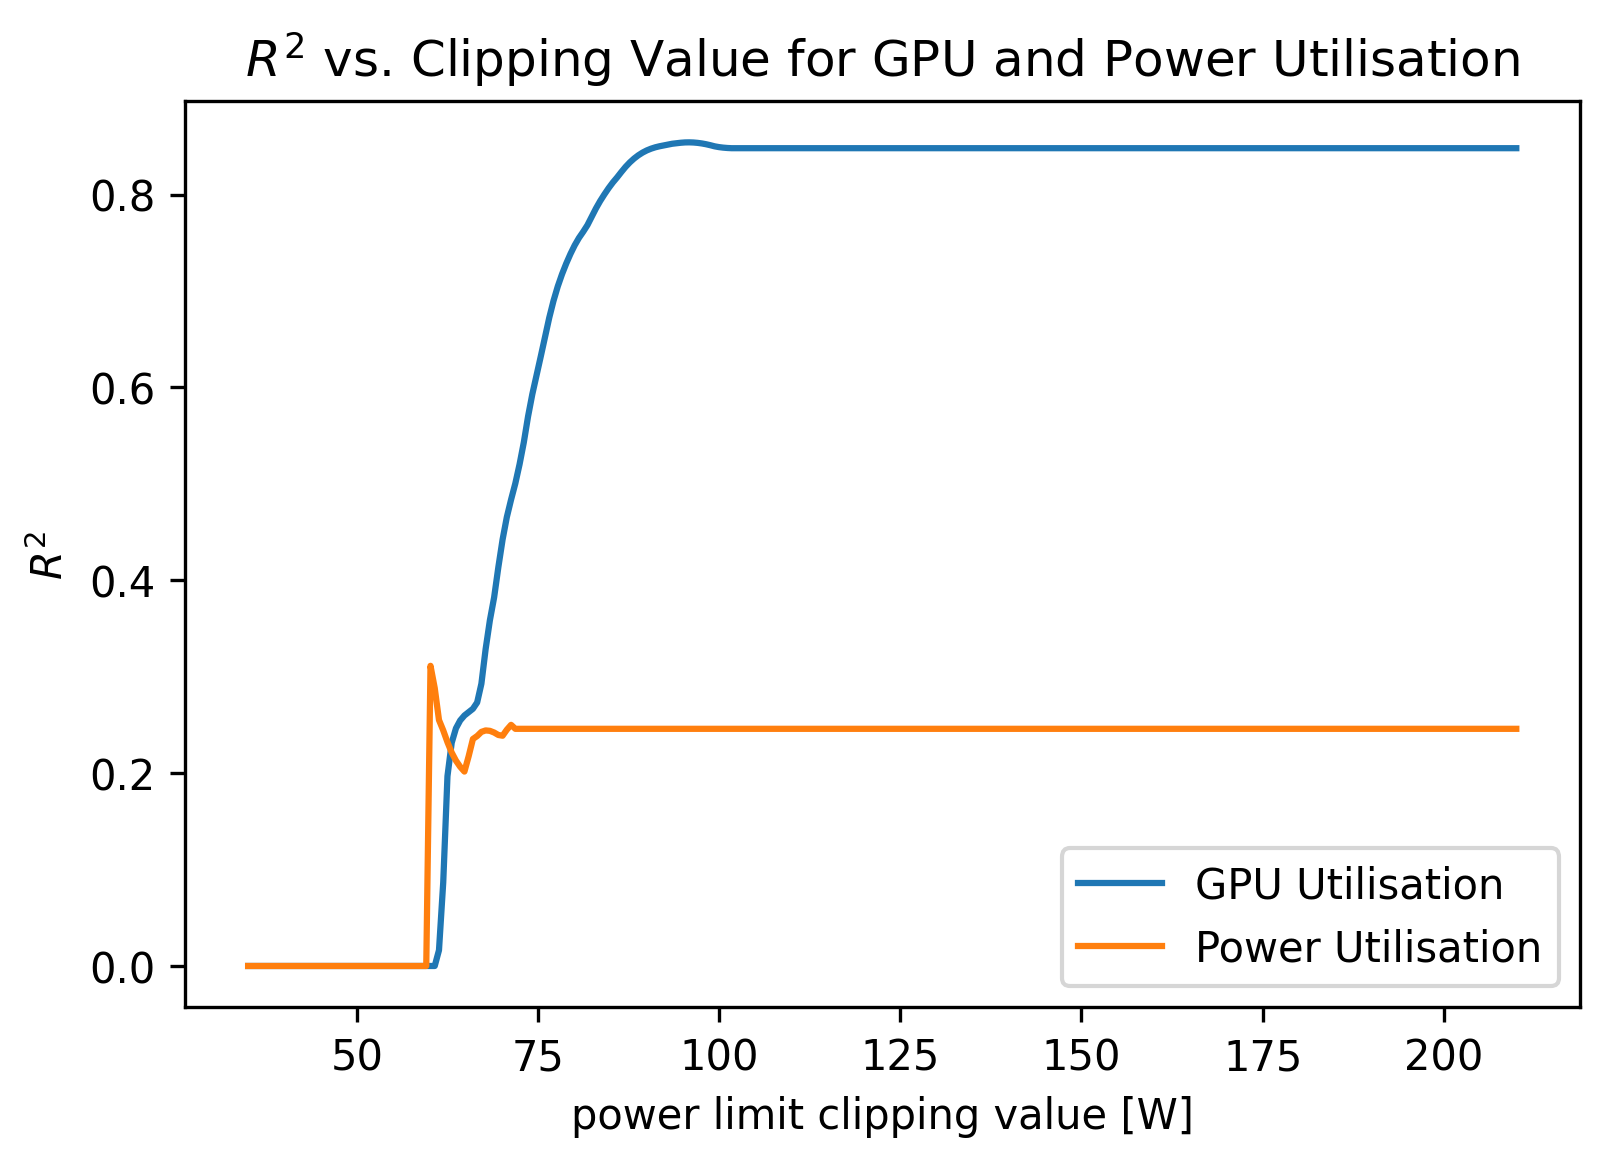

In [33]:
# train clock model
test_range = np.linspace(0.5,3,300)
r2_util_gpu = []
r2_p_util = []

for i in test_range:
    a_max = p_max_nominal * i#0.8
    clock_model = ClockModel()
    clock_model.fit(all_agg["enforced_power_limit"], all_agg["util_gpu_norm"], all_agg["clock_gpu"])
    #clock_model.plot_raw(all_agg, "util_gpu_norm")
    r2_util_gpu.append(clock_model.rsquared)
#    r2_util_gpu.append(np.sqrt(clock_model._model.mse_resid))
    clock_model.fit(all_agg["enforced_power_limit"], all_agg["p_util"], all_agg["clock_gpu"])
    r2_p_util.append(clock_model.rsquared)
    #r2_p_util.append(np.sqrt(clock_model._model.mse_resid))
plt.plot(test_range*p_max_nominal, r2_util_gpu)
plt.plot(test_range*p_max_nominal, r2_p_util)
plt.legend(["GPU Utilisation", "Power Utilisation"])
plt.xlabel("power limit clipping value [W]")
plt.ylabel("$R^2$")
plt.title("$R^2$ vs. Clipping Value for GPU and Power Utilisation")
#plt.savefig("../master-thesis/images/gpu-util-vs-power-util.pdf")

In [44]:
test_range[72]*300
r2_p_util[72]

0.9377726279354359

In [99]:
test_range[np.argmin(r2_util_gpu)]*300, test_range[np.argmin(r2_p_util)]*300

(252.8428093645485, 340.6354515050167)

In [45]:
test_range[np.argmax(r2_util_gpu)]*300, test_range[np.argmax(r2_p_util)]*300

(252.8428093645485, 340.6354515050167)

In [46]:
np.max(r2_p_util),np.max(r2_util_gpu)

(0.9402444819437866, 0.8609759261109983)

In [44]:
# train clock model
a_max = p_max_nominal * 1.3
clock_model = ClockModel()
clock_model.fit(all_agg["enforced_power_limit"], all_agg[util], all_agg["clock_gpu"])
# predict using model
all_agg["clock_gpu_hat"] = clock_model.predict(all_agg["enforced_power_limit"], all_agg[util])
clock_model.rsquared
#9669752108508707

0.8486741222353851

In [45]:
all_test = []
all_mses = []
for bench_name, test_data in all_agg.groupby("benchmark"):#
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    clock_model = ClockModel()
    clock_model.fit(train_data["enforced_power_limit"], train_data[util], train_data["clock_gpu"])
    
    test_data["clock_gpu_hat"] = clock_model.predict(test_data["enforced_power_limit"], test_data[util])
    all_test.append(test_data)
    mse_clock = mean_squared_error(test_data["clock_gpu"], test_data["clock_gpu_hat"])
    all_mses.append(mse_clock)

all_test = pd.concat(all_test)

NameError: name 'mean_squared_error' is not defined

In [87]:
np.sqrt(np.mean(all_mses)), np.sqrt(np.std(all_mses))

(53.679153605129535, 56.522789808593096)

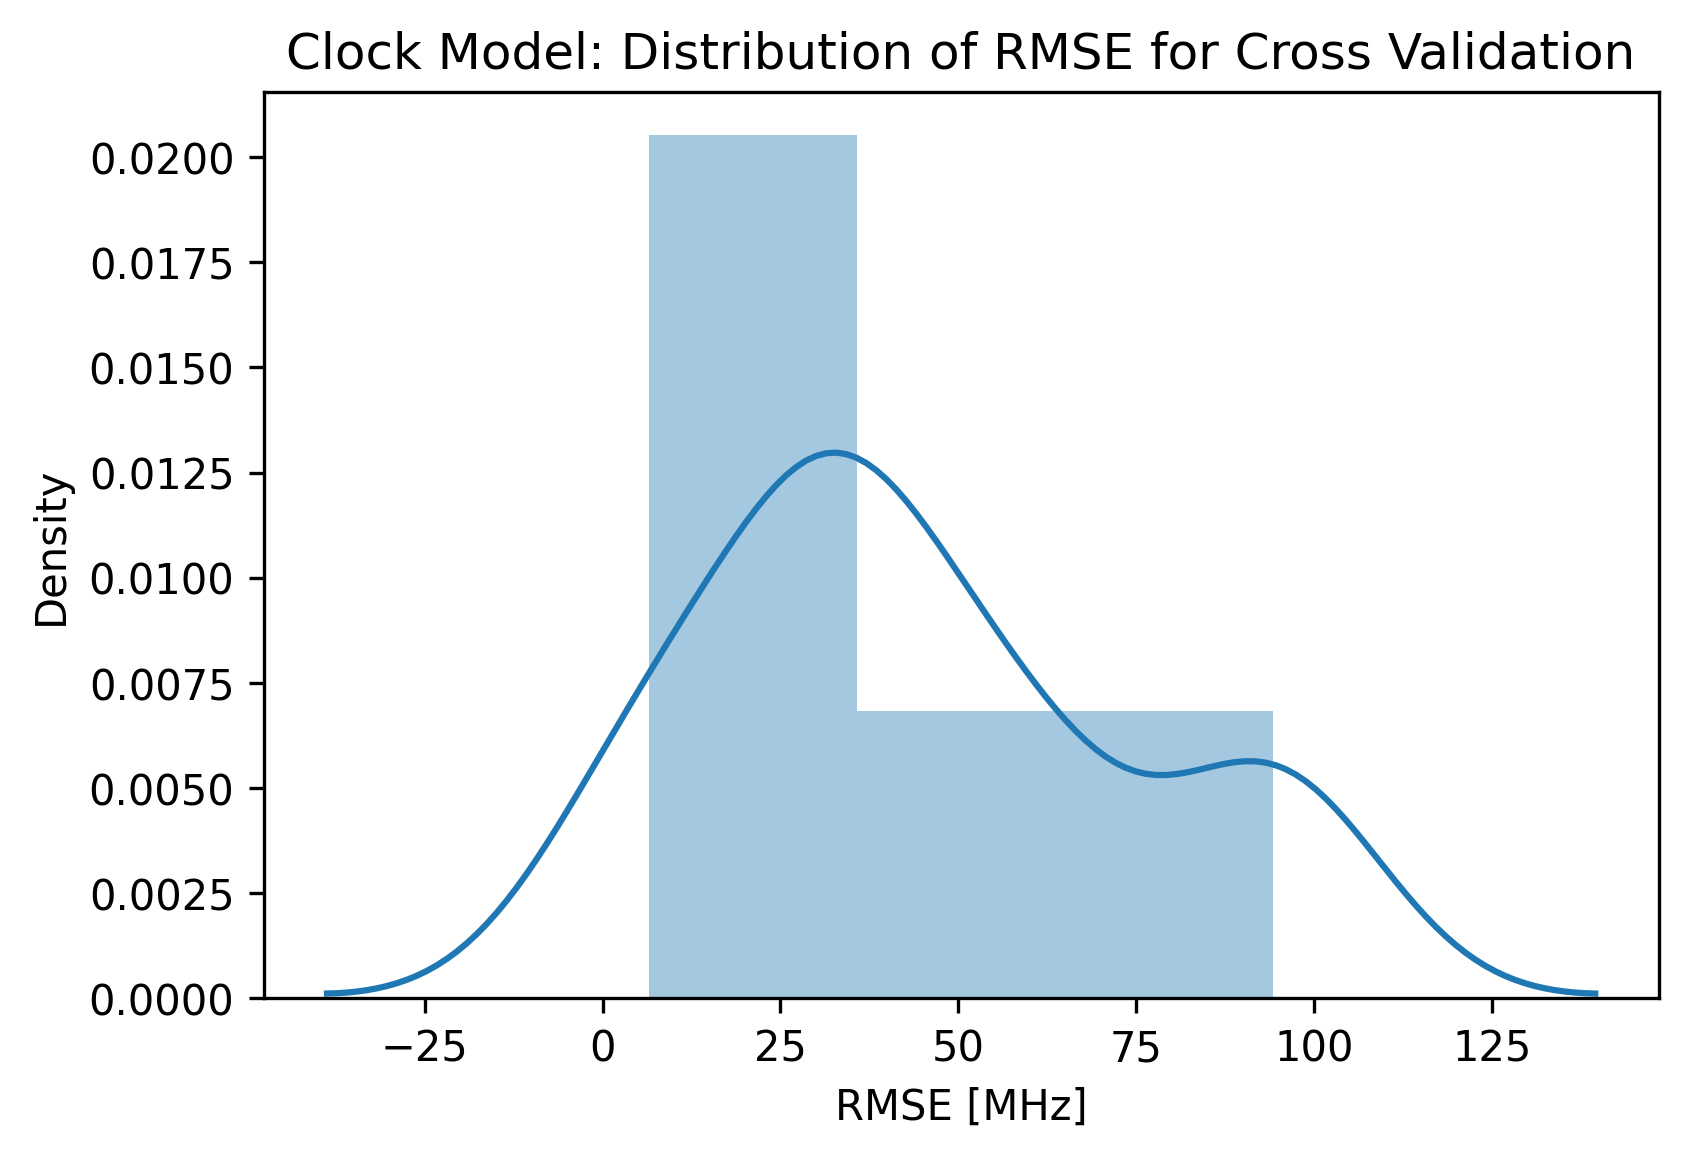

In [88]:
sns.distplot(np.sqrt(all_mses))
plt.title("Clock Model: Distribution of RMSE for Cross Validation")
plt.xlabel("RMSE [MHz]")
plt.ylabel("Density")
plt.savefig("../master-thesis/images/clock-model-rmse.pdf")

In [89]:
all_test = []
all_mses = []
for bench_name, test_data in all_agg[all_agg.benchmark != "nbody"].groupby("benchmark"):#
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    clock_model = ClockModel()
    clock_model.fit(train_data["enforced_power_limit"], train_data["p_util"], train_data["clock_gpu"])
    
    test_data["clock_gpu_hat"] = clock_model.predict(test_data["enforced_power_limit"], test_data["p_util"])
    all_test.append(test_data)
    mse_clock = mean_squared_error(test_data["clock_gpu"], test_data["clock_gpu_hat"])
    all_mses.append(mse_clock)

all_test = pd.concat(all_test)

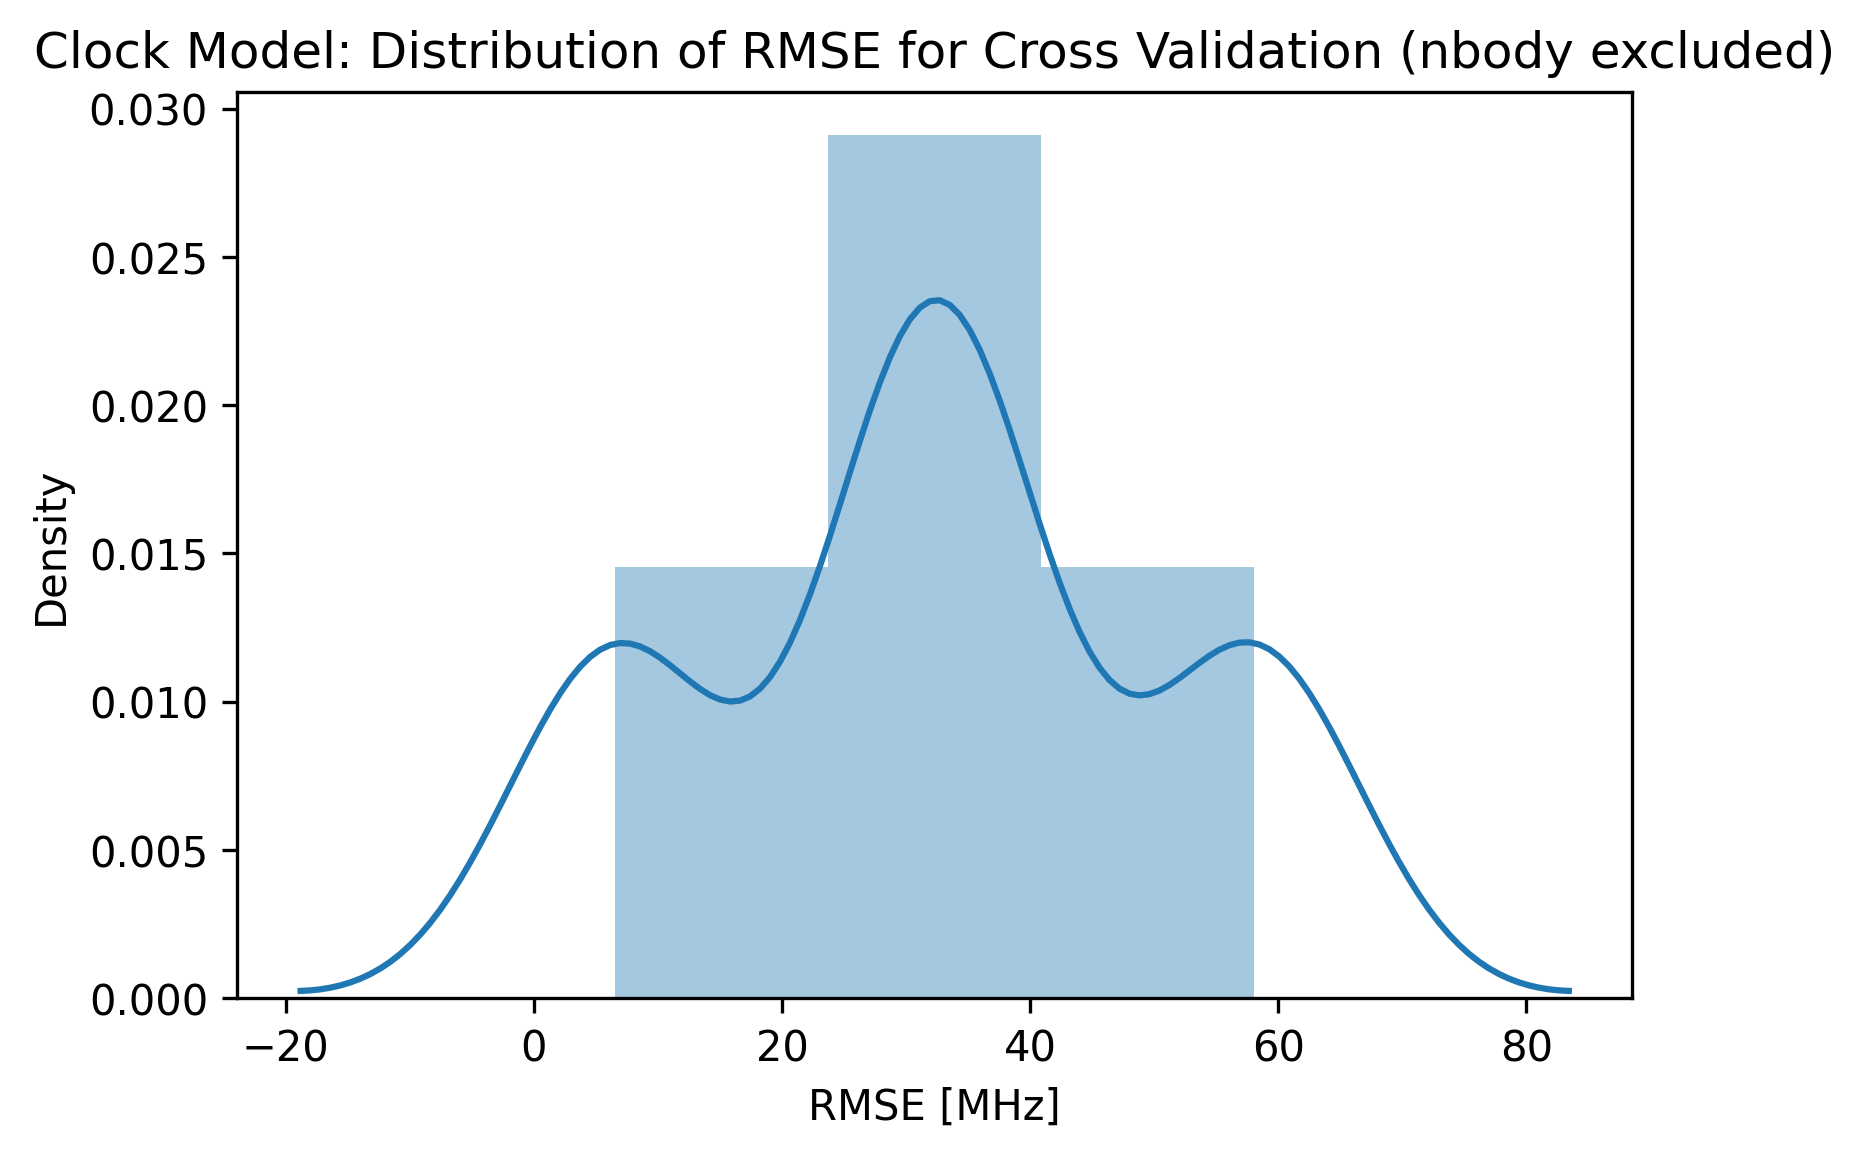

In [90]:
sns.distplot(np.sqrt(all_mses))
plt.title("Clock Model: Distribution of RMSE for Cross Validation (nbody excluded)")
plt.xlabel("RMSE [MHz]")
plt.ylabel("Density")
plt.savefig("../master-thesis/images/clock-model-rmse-no-nbody.pdf")

In [58]:
np.sqrt((np.array(all_mses)**2).sum()/len(all_mses))

53.679153605129535

In [53]:
mse_clock = mean_squared_error(all_agg["clock_gpu"], all_test["clock_gpu_hat"])
np.sqrt(mse_clock)

136.01166356496333

In [51]:
#clock_model._model.summary()
from sklearn.metrics import mean_squared_error
mse_clock = mean_squared_error(all_agg["clock_gpu"], all_agg["clock_gpu_hat"])
np.sqrt(mse_clock)

34.9786638018348

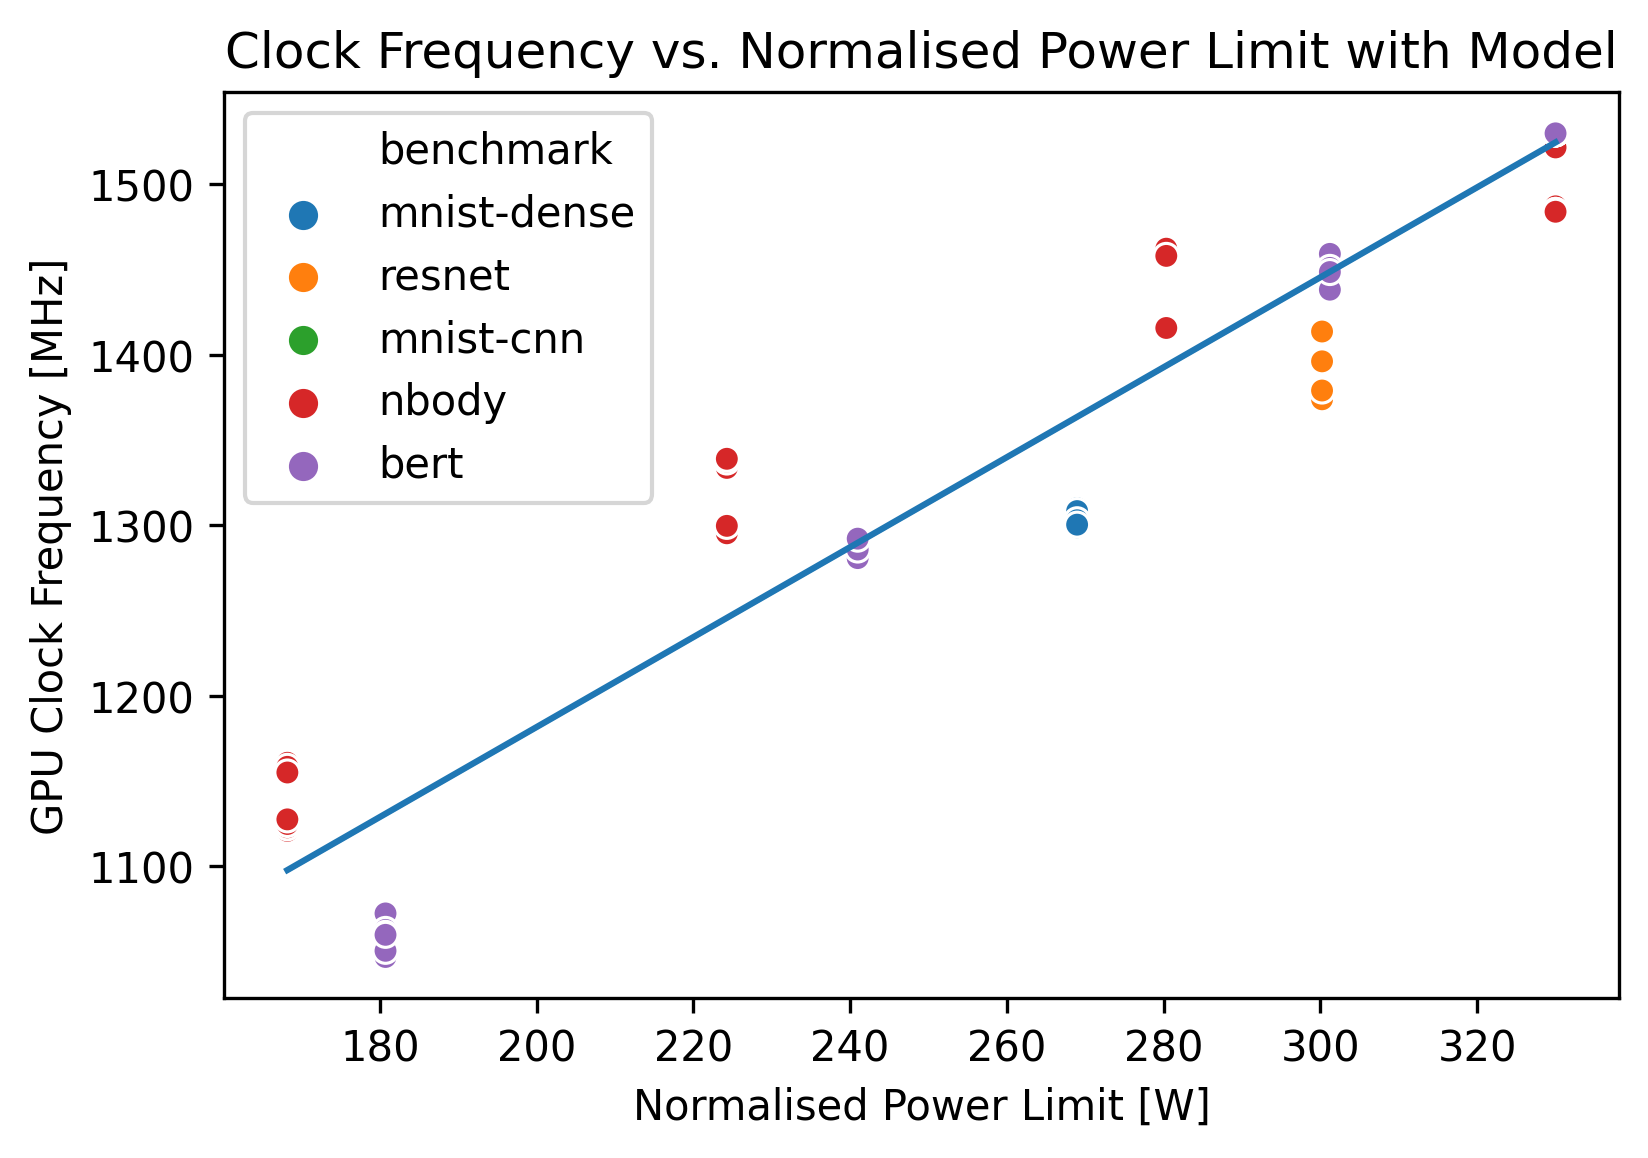

In [48]:
clock_model.plot_raw(all_agg)
plt.xlabel("Normalised Power Limit [W]")
plt.ylabel("GPU Clock Frequency [MHz]")
plt.title(f"Clock Frequency vs. Normalised Power Limit with Model")
plt.savefig("../master-thesis/images/norm-pl-clip-model.pdf")

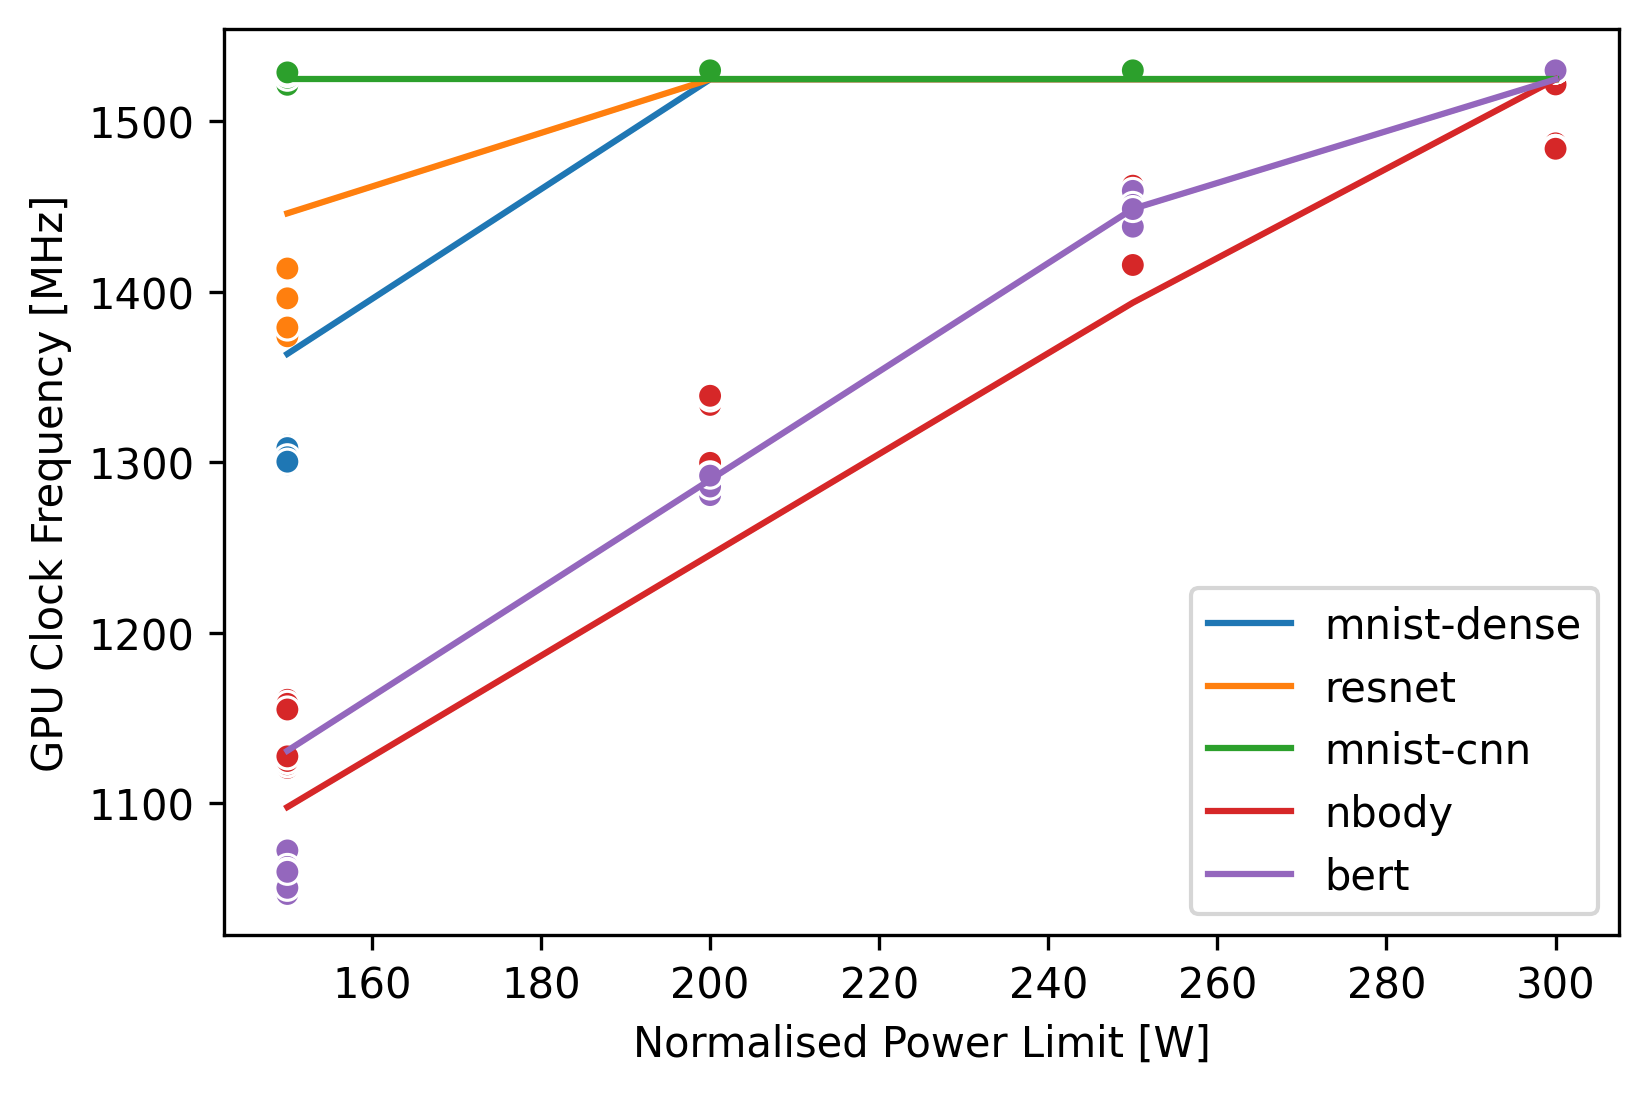

In [104]:
clock_model.plot(all_agg)
plt.legend(all_agg["benchmark"].unique())
plt.xlabel("Power Limit [W]")
plt.ylabel("GPU Clock Frequency [MHz]")
plt.savefig("../master-thesis/images/clock-model-per-benchmark.pdf")

In [171]:
print(all_agg.groupby(["benchmark"]).mean().rename(columns={"p_util": "$\\alpha_P$"})["$\\alpha_P$"].to_latex(float_format="%.3f",
                  escape=False,
                caption="Average power utilization on V100.",
                  label="tab:p-util-V100"
            ))

\begin{table}
\centering
\caption{Average power utilization on V100.}
\label{tab:p-util-V100}
\begin{tabular}{lr}
\toprule
{} &  $\alpha_P$ \\
benchmark   &             \\
\midrule
bert        &       0.830 \\
mnist-cnn   &       0.362 \\
mnist-dense &       0.558 \\
nbody       &       0.892 \\
resnet      &       0.500 \\
\bottomrule
\end{tabular}
\end{table}



In [210]:
power_model = PowerModel()
power_model.fit(all_agg["p_util"], all_agg["clock_gpu"], all_agg["power"])
all_agg["power_hat"] = power_model.predict(all_agg["p_util"], all_agg["clock_gpu"])
power_model.rsquared, np.sqrt(power_model._model.mse_resid)

(0.9783053508383709, 6.175820228950362)

In [124]:
all_test = []
all_mses = []
for bench_name, test_data in all_agg.groupby("benchmark"):#
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    power_model = PowerModel()
    power_model.fit(train_data["p_util"], train_data["clock_gpu"], train_data["power"])
    
    test_data["power_hat"] = power_model.predict(test_data["p_util"], test_data["clock_gpu"])
    all_test.append(test_data)
    mse_clock = mean_squared_error(test_data["power"], test_data["power_hat"])
    all_mses.append(mse_clock)

all_test = pd.concat(all_test)

In [125]:
np.sqrt(np.mean(all_mses)), np.sqrt(np.std(all_mses))

(9.72748974036296, 10.408556220146648)

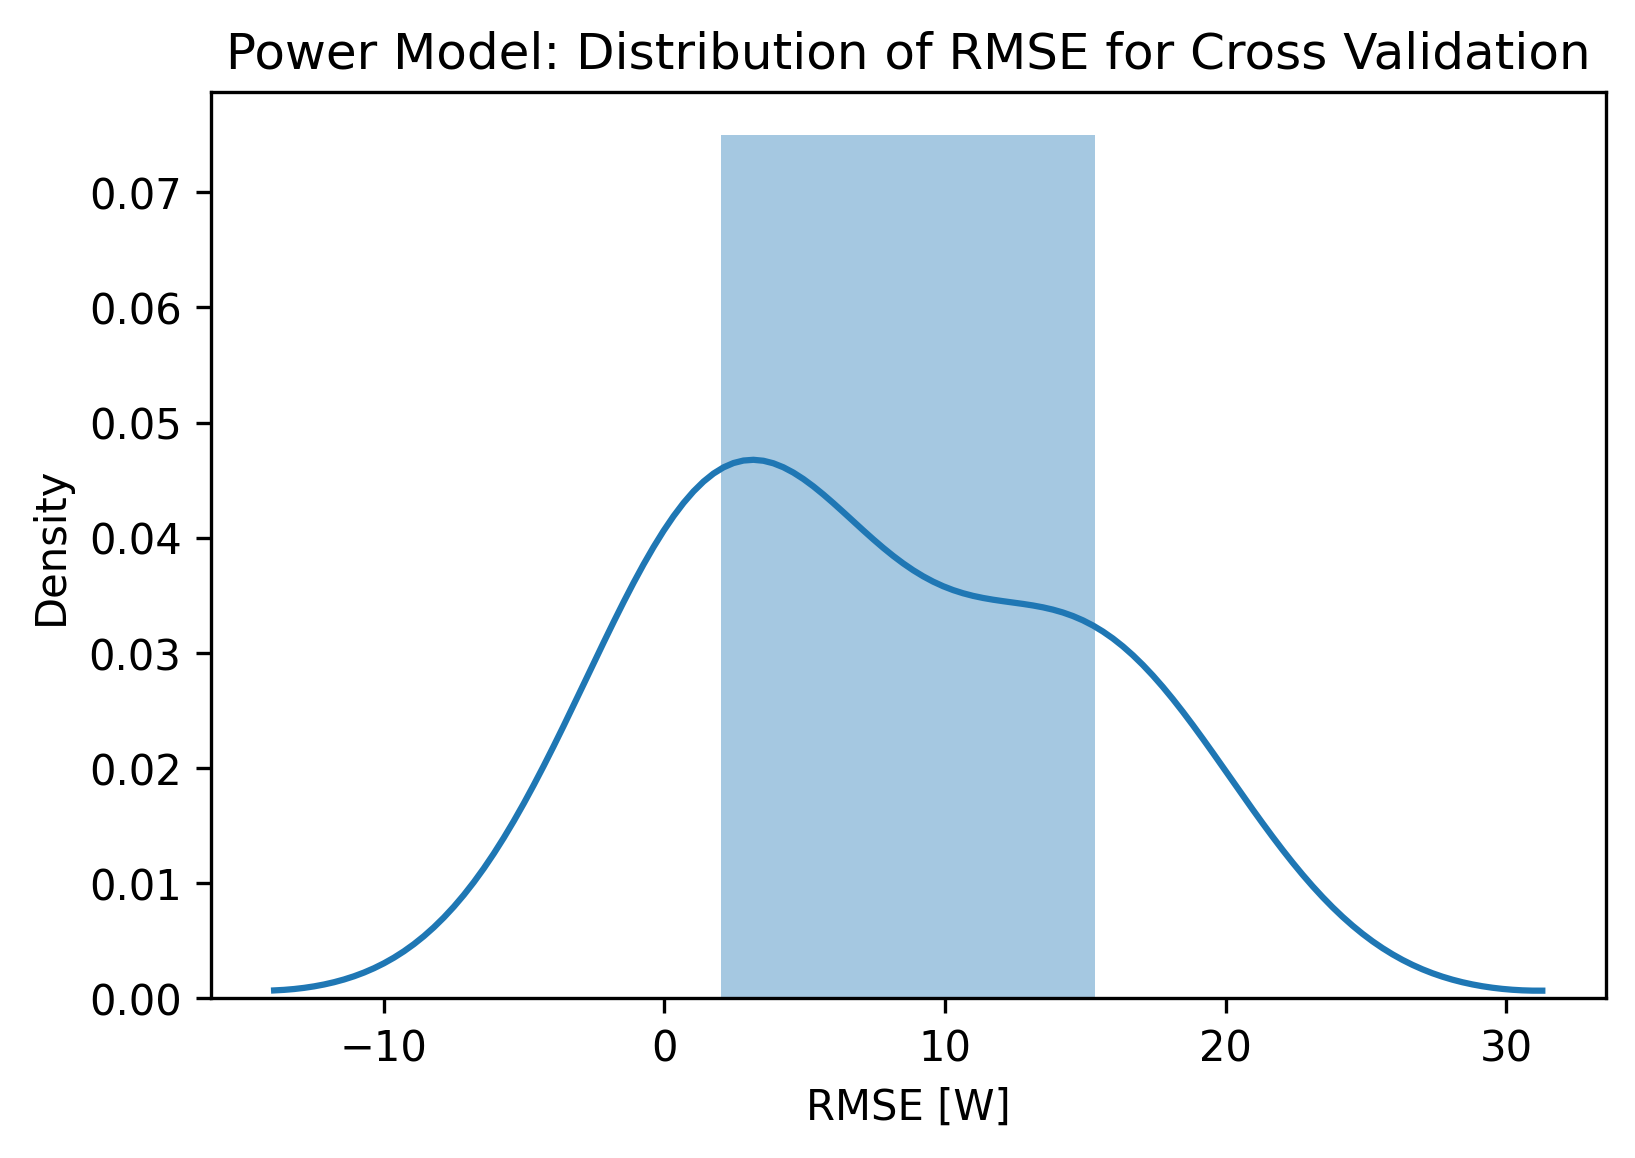

In [127]:
sns.distplot(np.sqrt(all_mses))
plt.title("Power Model: Distribution of RMSE for Cross Validation")
plt.xlabel("RMSE [W]")
plt.ylabel("Density")
plt.savefig("../master-thesis/images/power-model-rmse.pdf")

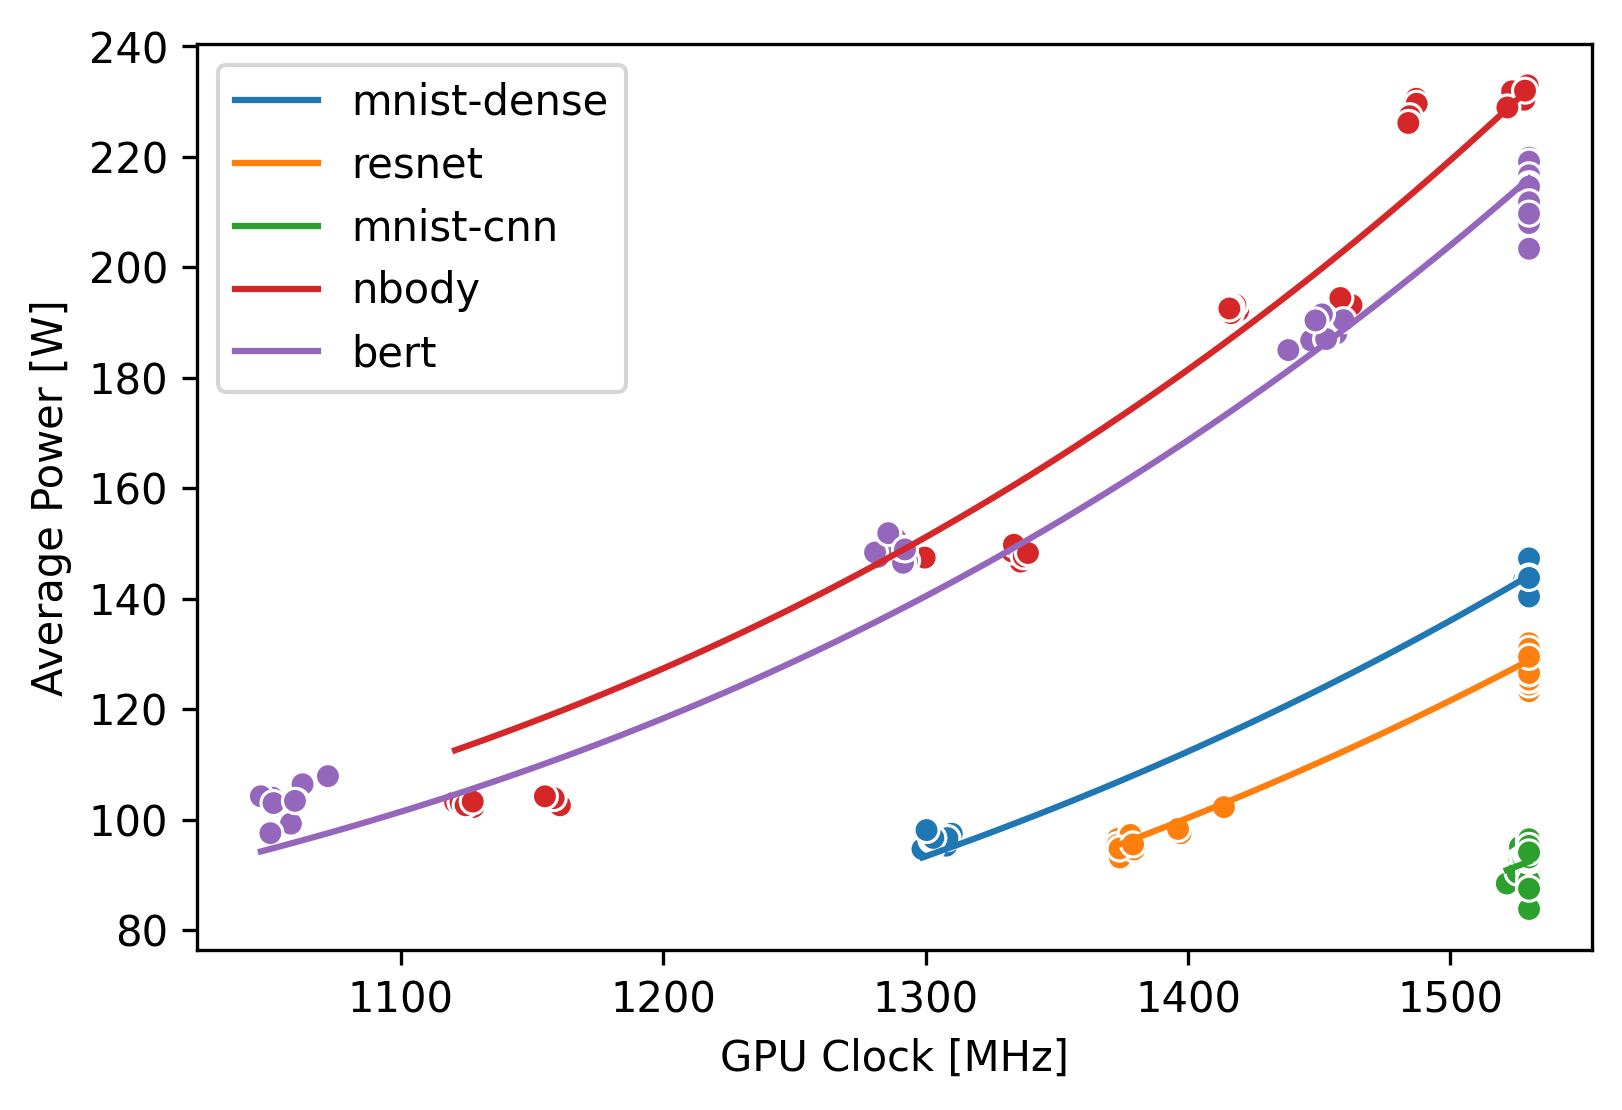

In [110]:
power_model.plot(all_agg)
plt.legend(all_agg["benchmark"].unique())
plt.xlabel("GPU Clock [MHz]")
plt.ylabel("Average Power [W]")
plt.savefig("../master-thesis/images/power-model-per-benchmark.pdf")

In [211]:
delay_model = DelayModel()
delay_model.fit(all_agg["clock_gpu"], all_agg["delay"])
delay_model.rsquared, np.sqrt(delay_model._model.mse_resid)*100

(0.8457801630804331, 3.5013253965683235)

In [135]:
all_test = []
all_mses = []
for bench_name, test_data in all_agg.groupby("benchmark"):#
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    delay_model = DelayModel()
    delay_model.fit(train_data["clock_gpu"], train_data["delay"])

    test_data["delay_hat"] = delay_model.predict(test_data["clock_gpu"])
    all_test.append(test_data)
    mse_clock = mean_squared_error(test_data["delay"], test_data["delay_hat"])
    all_mses.append(mse_clock)

all_test = pd.concat(all_test)

In [138]:
np.sqrt(np.mean(all_mses))*100, np.sqrt(np.std(all_mses))*100

(5.242594700550556, 5.38472297991511)

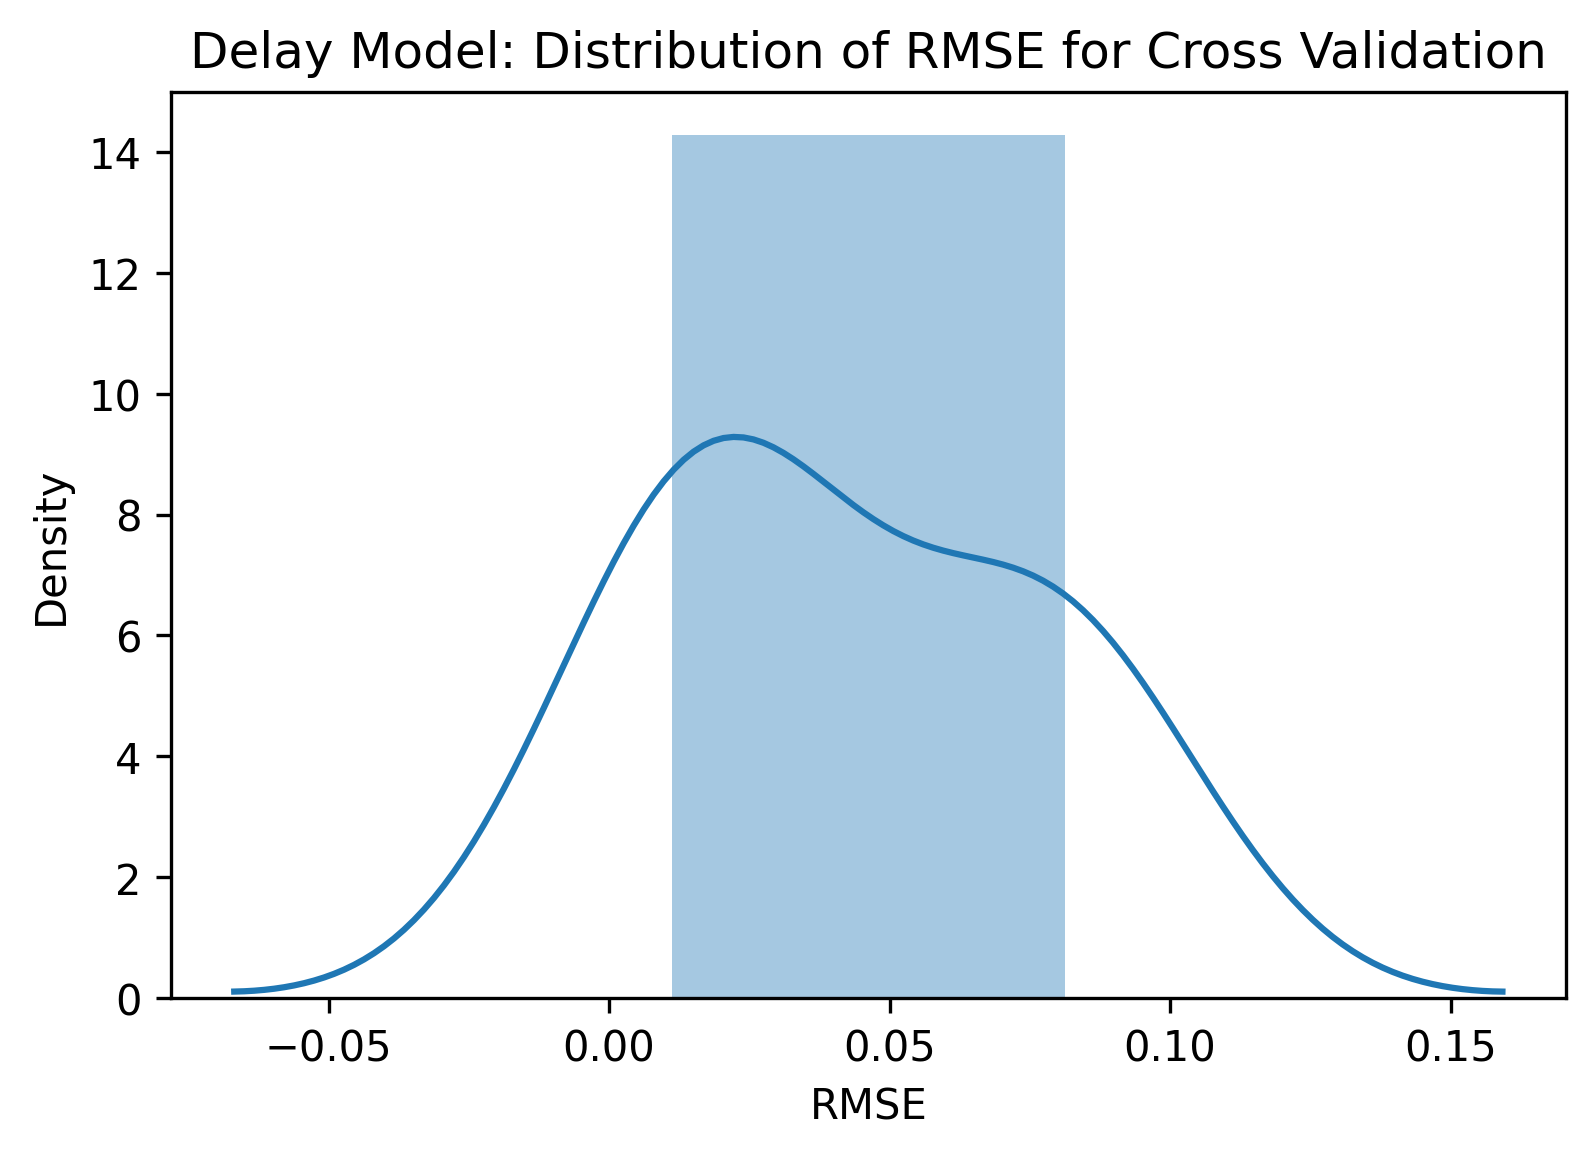

In [141]:
sns.distplot(np.sqrt(all_mses))
plt.title("Delay Model: Distribution of RMSE for Cross Validation")
plt.xlabel("RMSE")
plt.ylabel("Density")
plt.savefig("../master-thesis/images/delay-model-rmse.pdf")

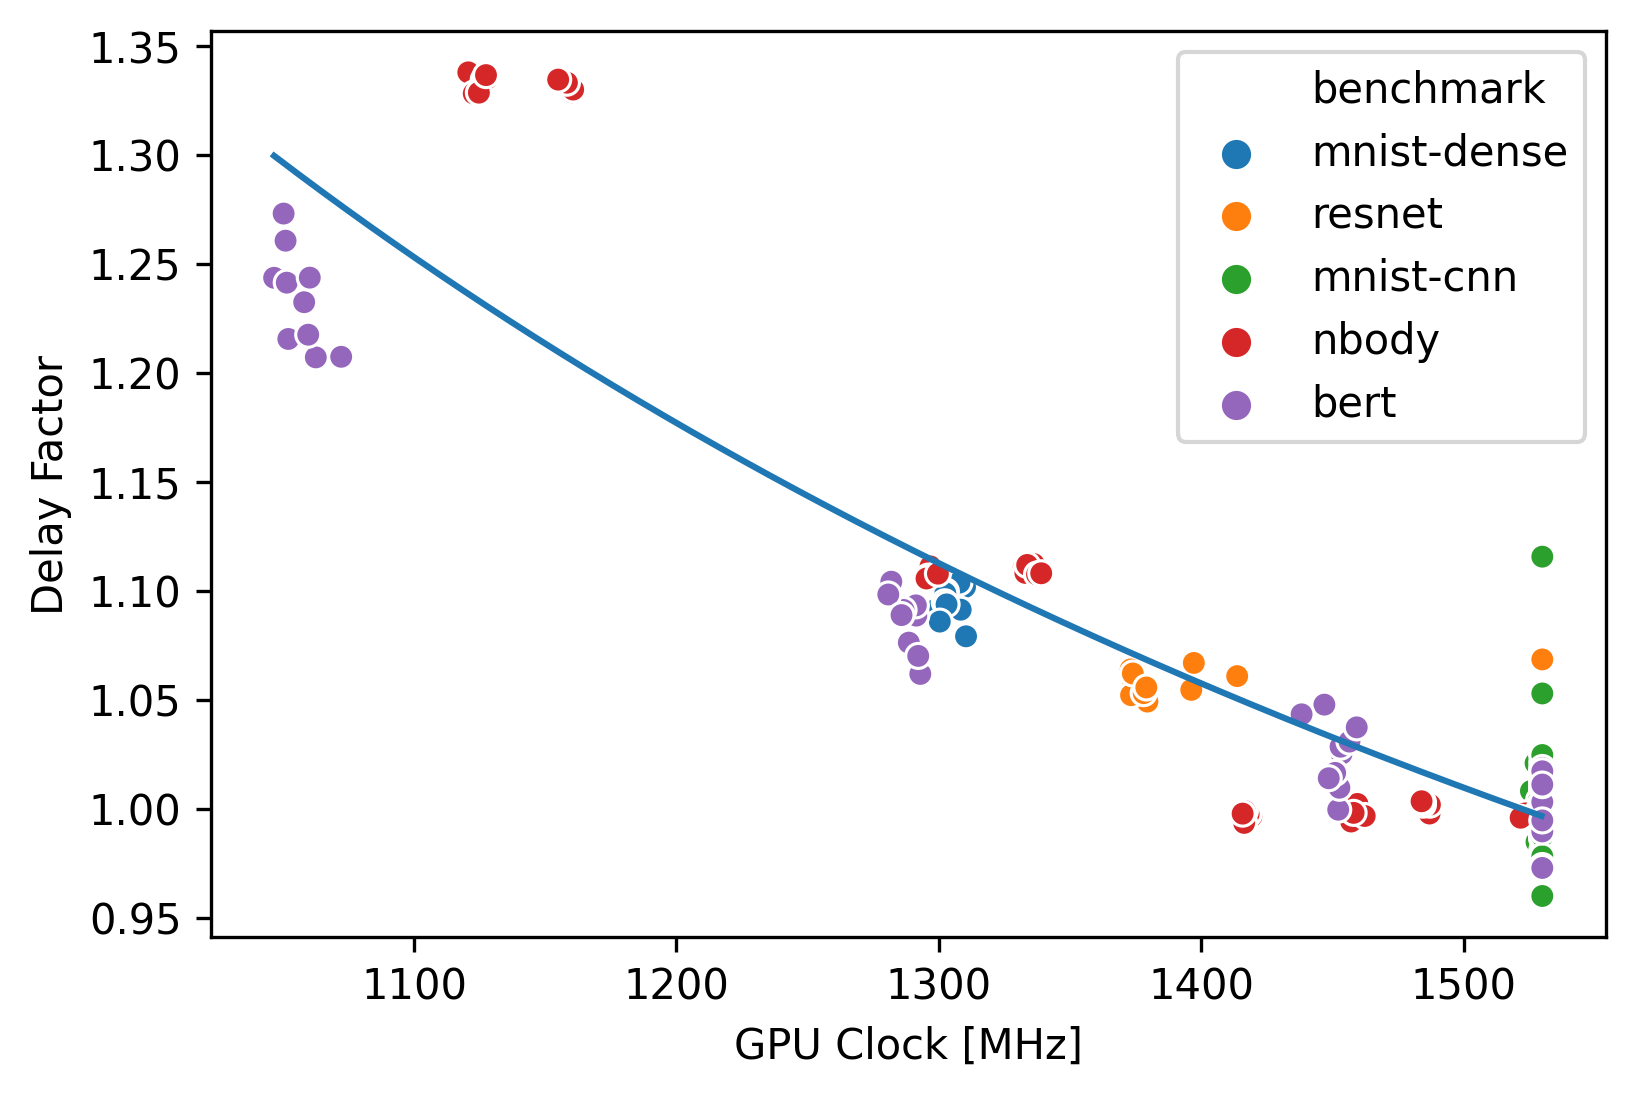

In [133]:
delay_model.plot_model(all_agg)
plt.xlabel("GPU Clock [MHz]")
plt.ylabel("Delay Factor")
plt.savefig("../master-thesis/images/delay-model-per-benchmark.pdf")

In [212]:
energy_model = EnergyModel(delay_model=delay_model, power_model=power_model, clock_model=clock_model)

In [213]:
all_agg["energy_hat"] = energy_model.predict(p_util=all_agg["p_util"], power_limit=all_agg["enforced_power_limit"], time_reference=all_agg["time_reference"])

In [214]:
mse_clock = mean_squared_error(all_agg["energy"], all_agg["energy_hat"])
np.sqrt(mse_clock)

1.321157119460618

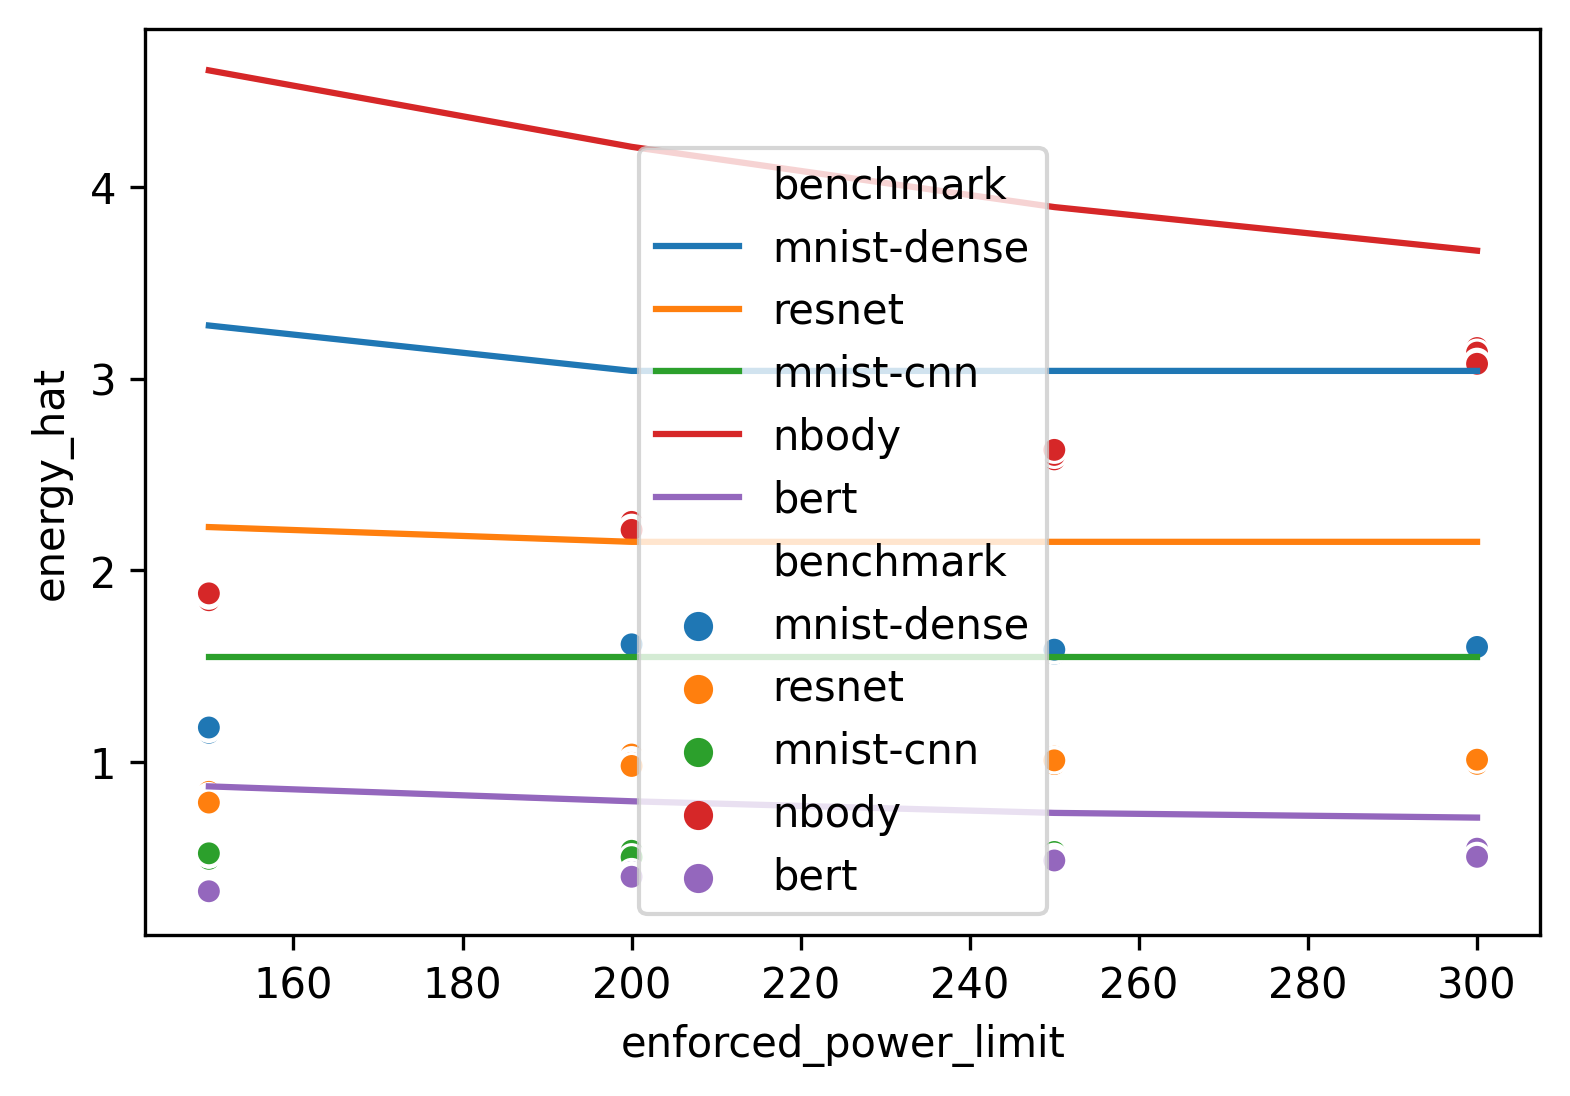

In [215]:
plot_model("enforced_power_limit", "energy", all_agg)

<AxesSubplot:xlabel='enforced_power_limit'>

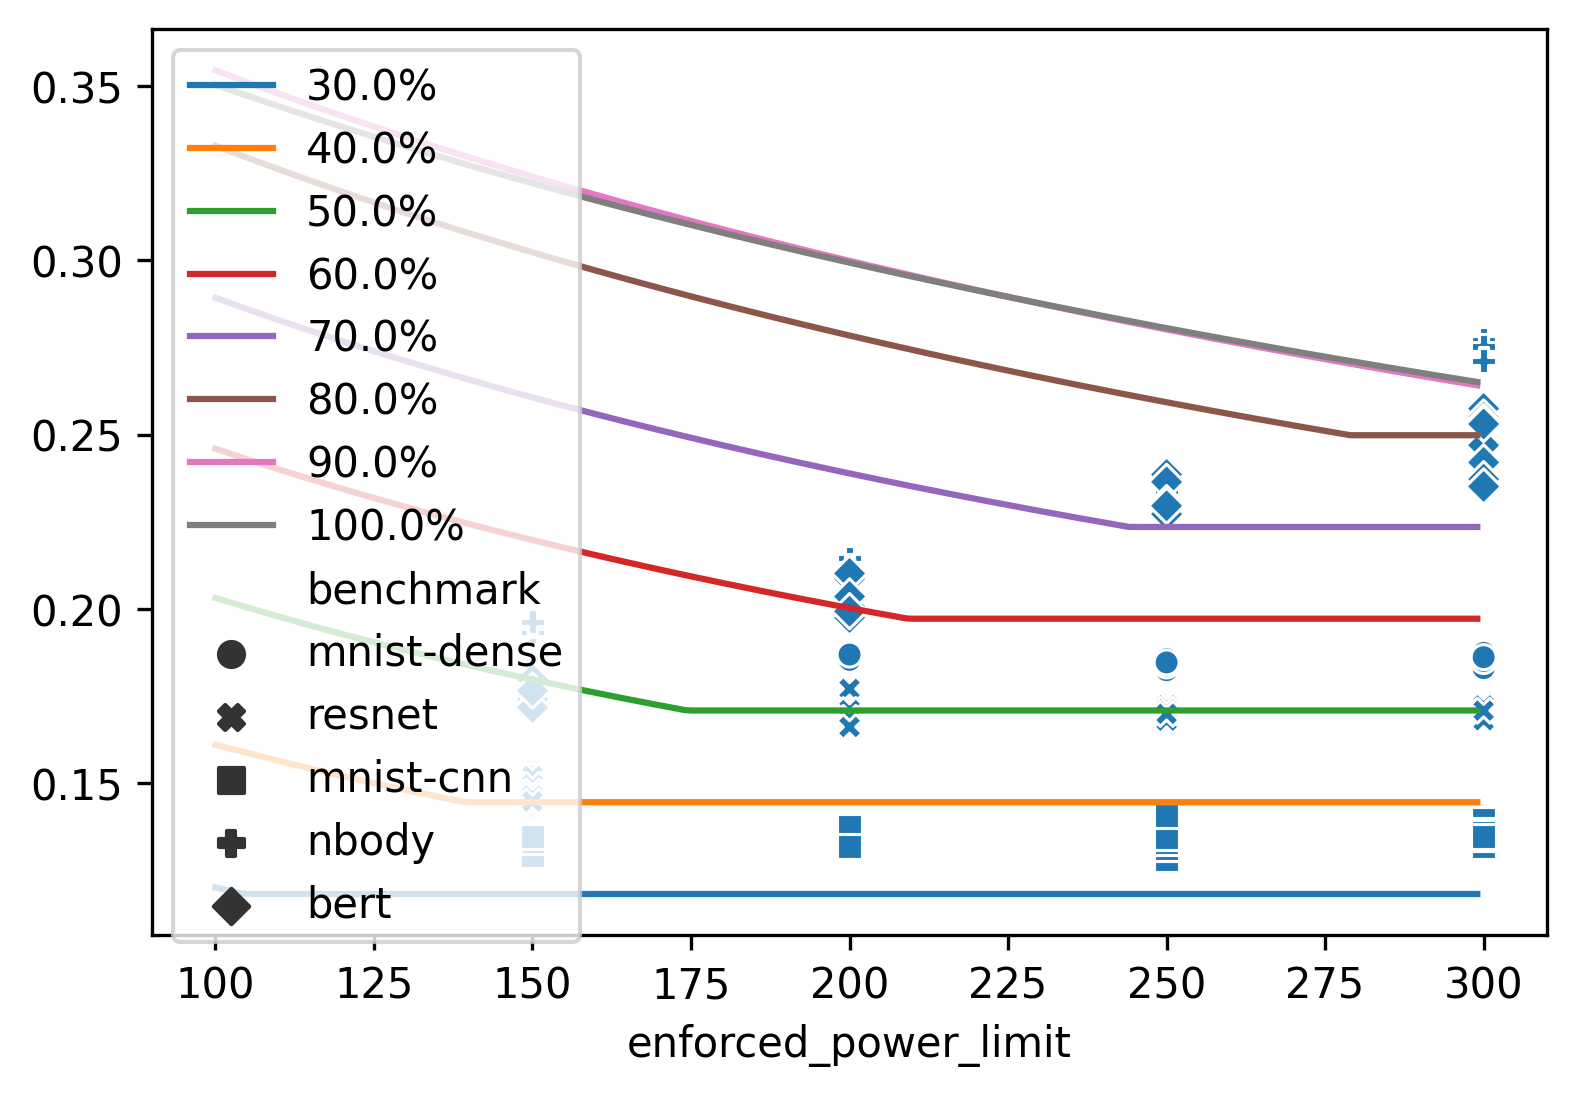

In [183]:
x = np.arange(100,p_max_nominal)
for i in range(3,11):
    y = energy_model.predict(x, i/10, 1)#/0.3
    plt.plot(x, y, label=f"{i/10*100}%")

sns.scatterplot(all_agg["enforced_power_limit"],all_agg["energy"]/all_agg["time_reference"], style=all_agg["benchmark"])
#plt.legend()

In [184]:
clock_model._model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              clock_gpu   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     3020.
Date:                Wed, 17 Feb 2021   Prob (F-statistic):          7.67e-122
Time:                        14:10:44   Log-Likelihood:                -993.16
No. Observations:                 200   AIC:                             1990.
Df Residuals:                     198   BIC:                             1997.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        730.2476     13.071     55.870      0.000     704.472     756.023
relative_power     2.2935      0.042     54.955      0.000       2.211       2.376
==============================================================================
Omnibus:                       13.072   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               33.220
Skew:                           0.114   Prob(JB):                     6.11e-08
Kurtosis:                       4.984   Cond. No.                     1.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [185]:
res["energy_hat"] = energy_model.predict(res["enforced_power_limit"], res["p_util"], res["time_reference"])

NameError: name 'res' is not defined

In [269]:
no_res["energy_hat"] = energy_model.predict(no_res["enforced_power_limit"], no_res["p_util"], no_res["time_reference"])

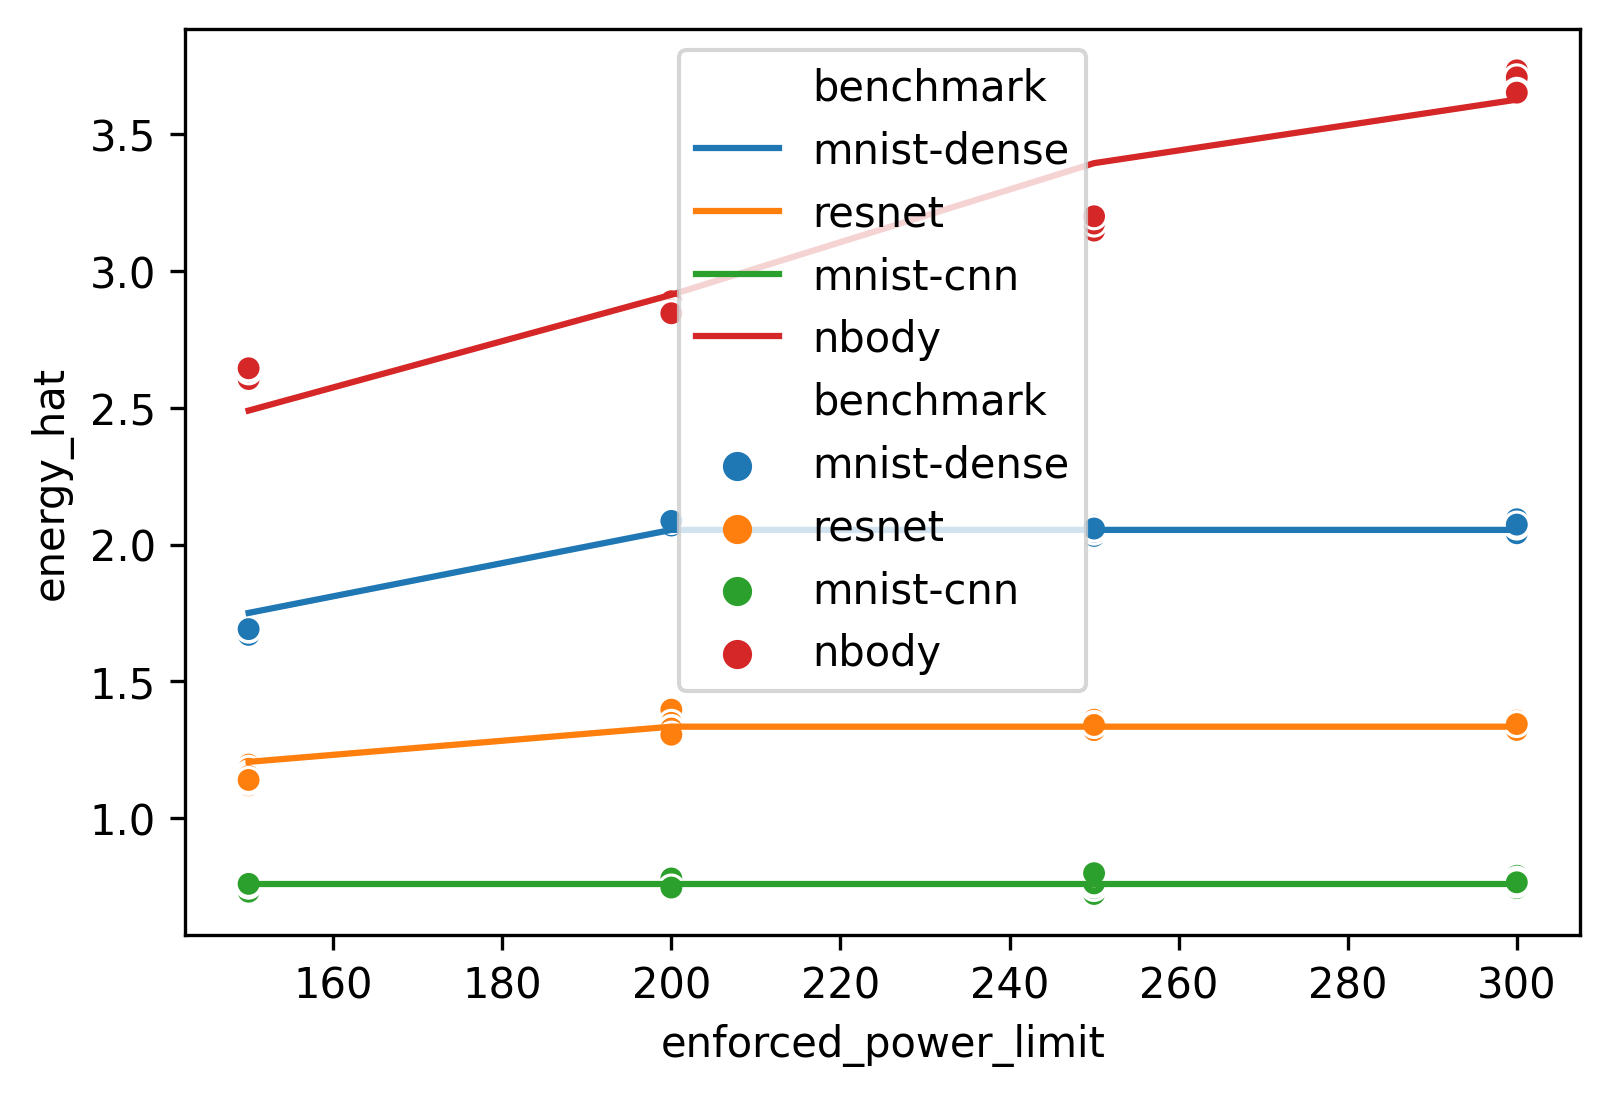

In [271]:
plot_model("enforced_power_limit","energy", no_res)

0.9258258671283486

In [15]:
all_test = []
for bench_name, test_data in all_agg.groupby("benchmark"):
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    clock_model = get_clock_model(train_data)
    
    test_data["clock_gpu_hat"] = clock_model.predict(test_data) *  f_max
    all_test.append(test_data)

all_test = pd.concat(all_test)
#rmse(all_test, "clock_gpu")
all_agg["clock_gpu_hat"] = all_test["clock_gpu_hat"]

In [28]:
#plot_model("clock_gpu","power",  all_agg, hue="benchmark")

In [172]:
all_test = []
for bench_name, test_data in all_agg.groupby("benchmark"):
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    power_model = get_power_model(train_data)
    
    test_data["power_hat"] = power_model.predict(test_data)
    all_test.append(test_data)

all_test = pd.concat(all_test)
all_agg["power_hat"] = all_test["power_hat"]

In [25]:
delay_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delay   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     2471.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):          8.41e-114
Time:                        10:27:38   Log-Likelihood:                 460.82
No. Observations:                 200   AIC:                            -917.6
Df Residuals:                     198   BIC:                            -911.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2882      0.015     18.746      0.000       0.258       0.318
d1          1078.5572     21.696     49.713      0.000    1035.773    1121.341
==============================================================================
Omnibus:                       35.670   Durbin-Watson:                   0.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.964
Skew:                           0.813   Prob(JB):                     4.33e-18
Kurtosis:                       5.637   Cond. No.                     1.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

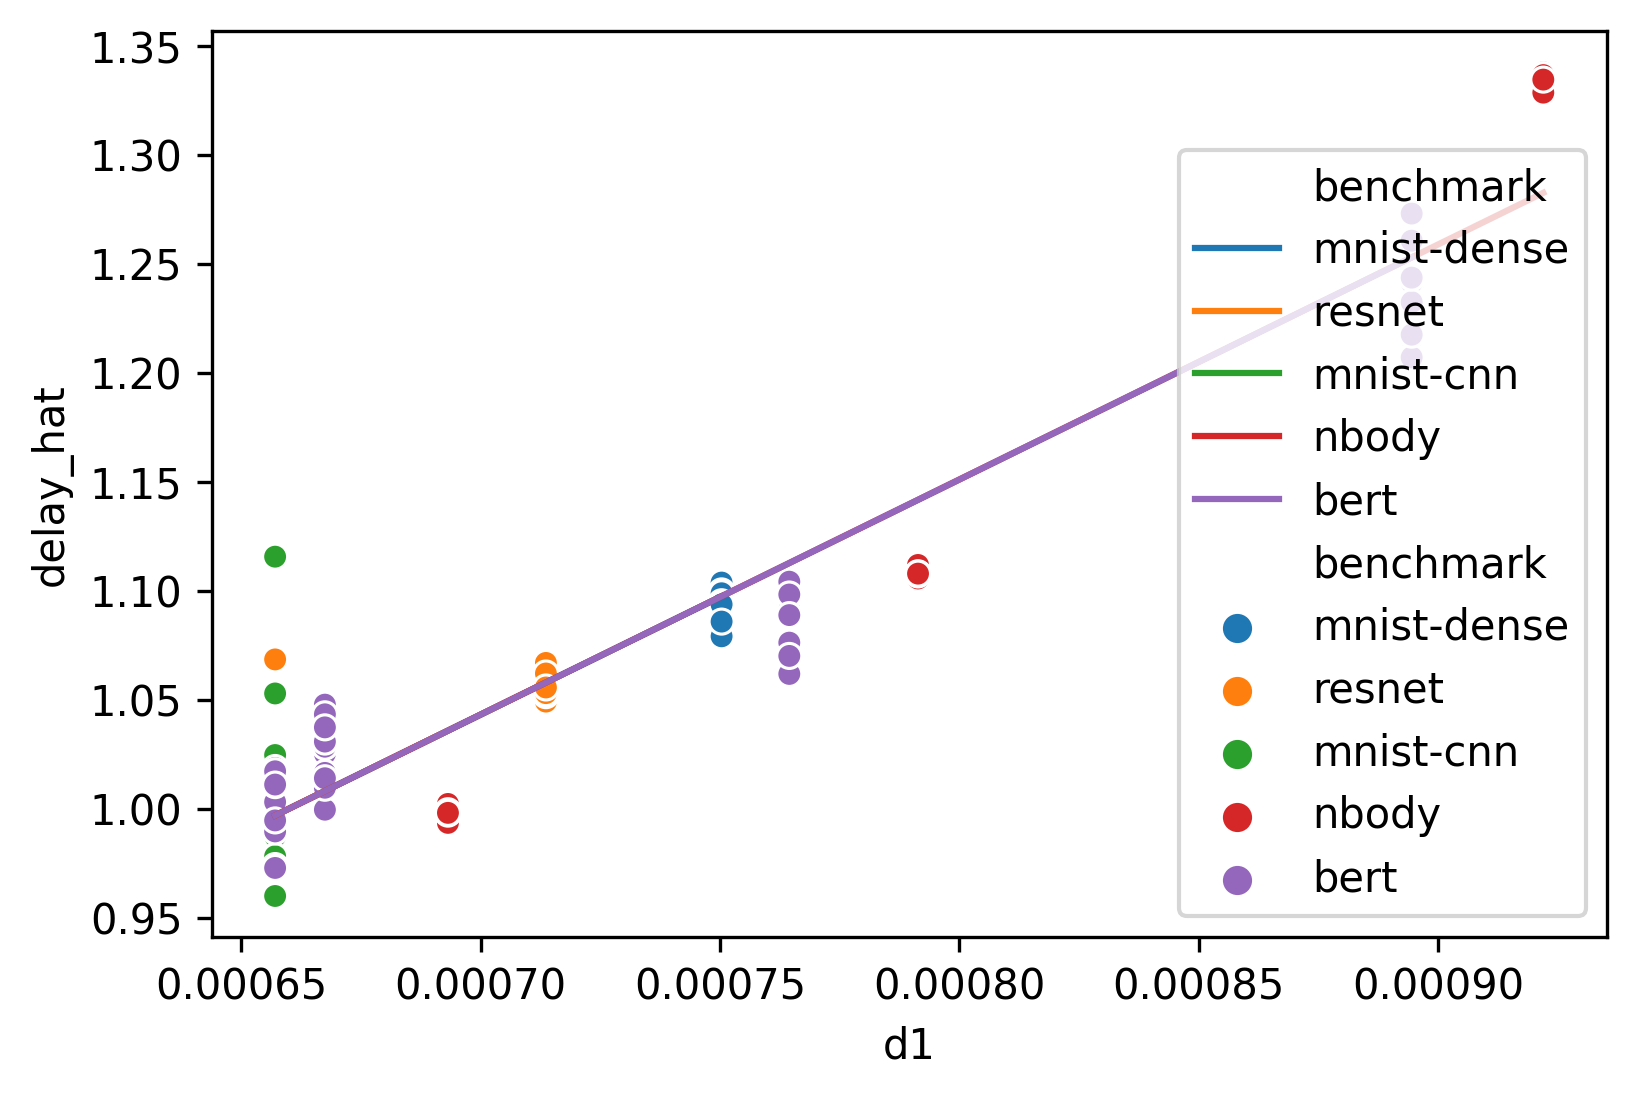

In [26]:
plot_model("d1", "delay",  all_agg, hue="benchmark")

In [148]:
all_test = []
for bench_name, test_data in all_agg.groupby("benchmark"):
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    delay_model = get_delay_model(all_agg)
    
    test_data["delay_hat"] = delay_model.predict(test_data)
    all_test.append(test_data)

all_test = pd.concat(all_test)
all_agg["delay_hat"] = all_test["delay_hat"]
all_agg["time_hat"] =  all_agg["time_reference"] * all_agg["delay_hat"]
all_agg["energy_hat"] = (all_agg["power_hat"] * all_agg["time_hat"]) / 1_000

In [38]:
rmse(all_agg, "clock_gpu")

29.409913771467178

<AxesSubplot:xlabel='enforced_power_limit', ylabel='clock_gpu'>

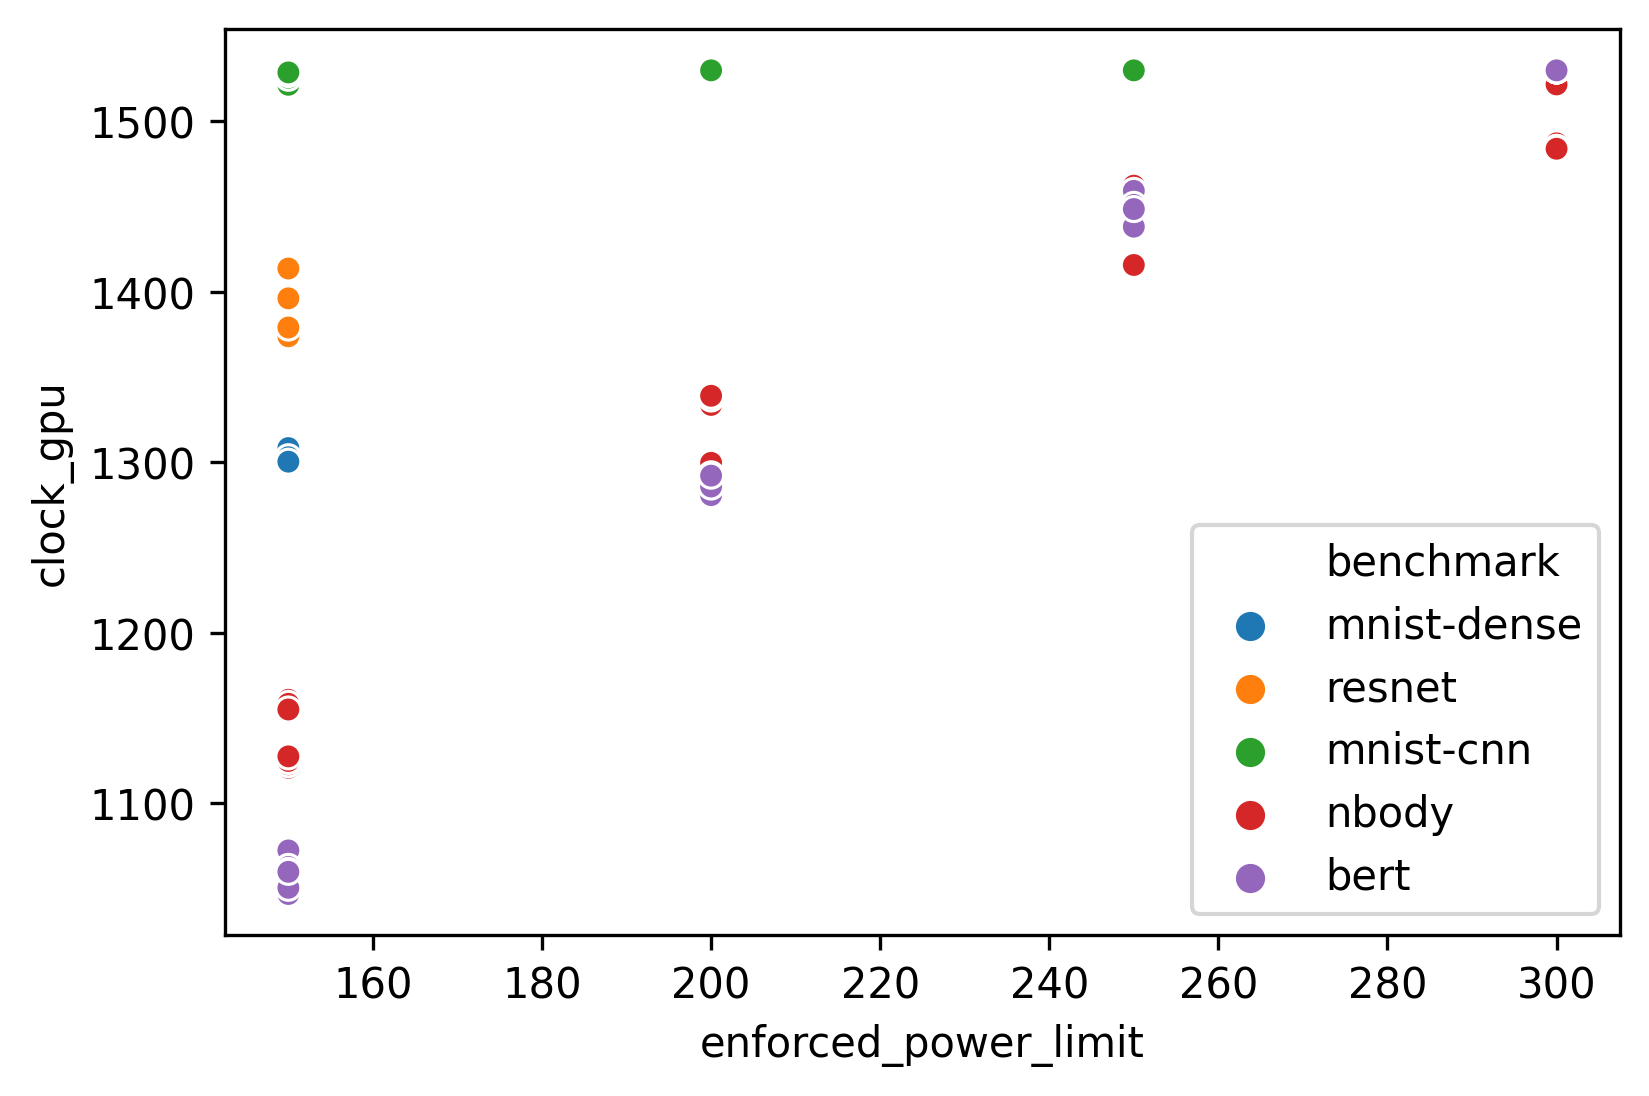

In [40]:
sns.scatterplot(x="enforced_power_limit",y="clock_gpu",hue="benchmark", data=all_agg)

<AxesSubplot:xlabel='enforced_power_limit', ylabel='energy_hat'>

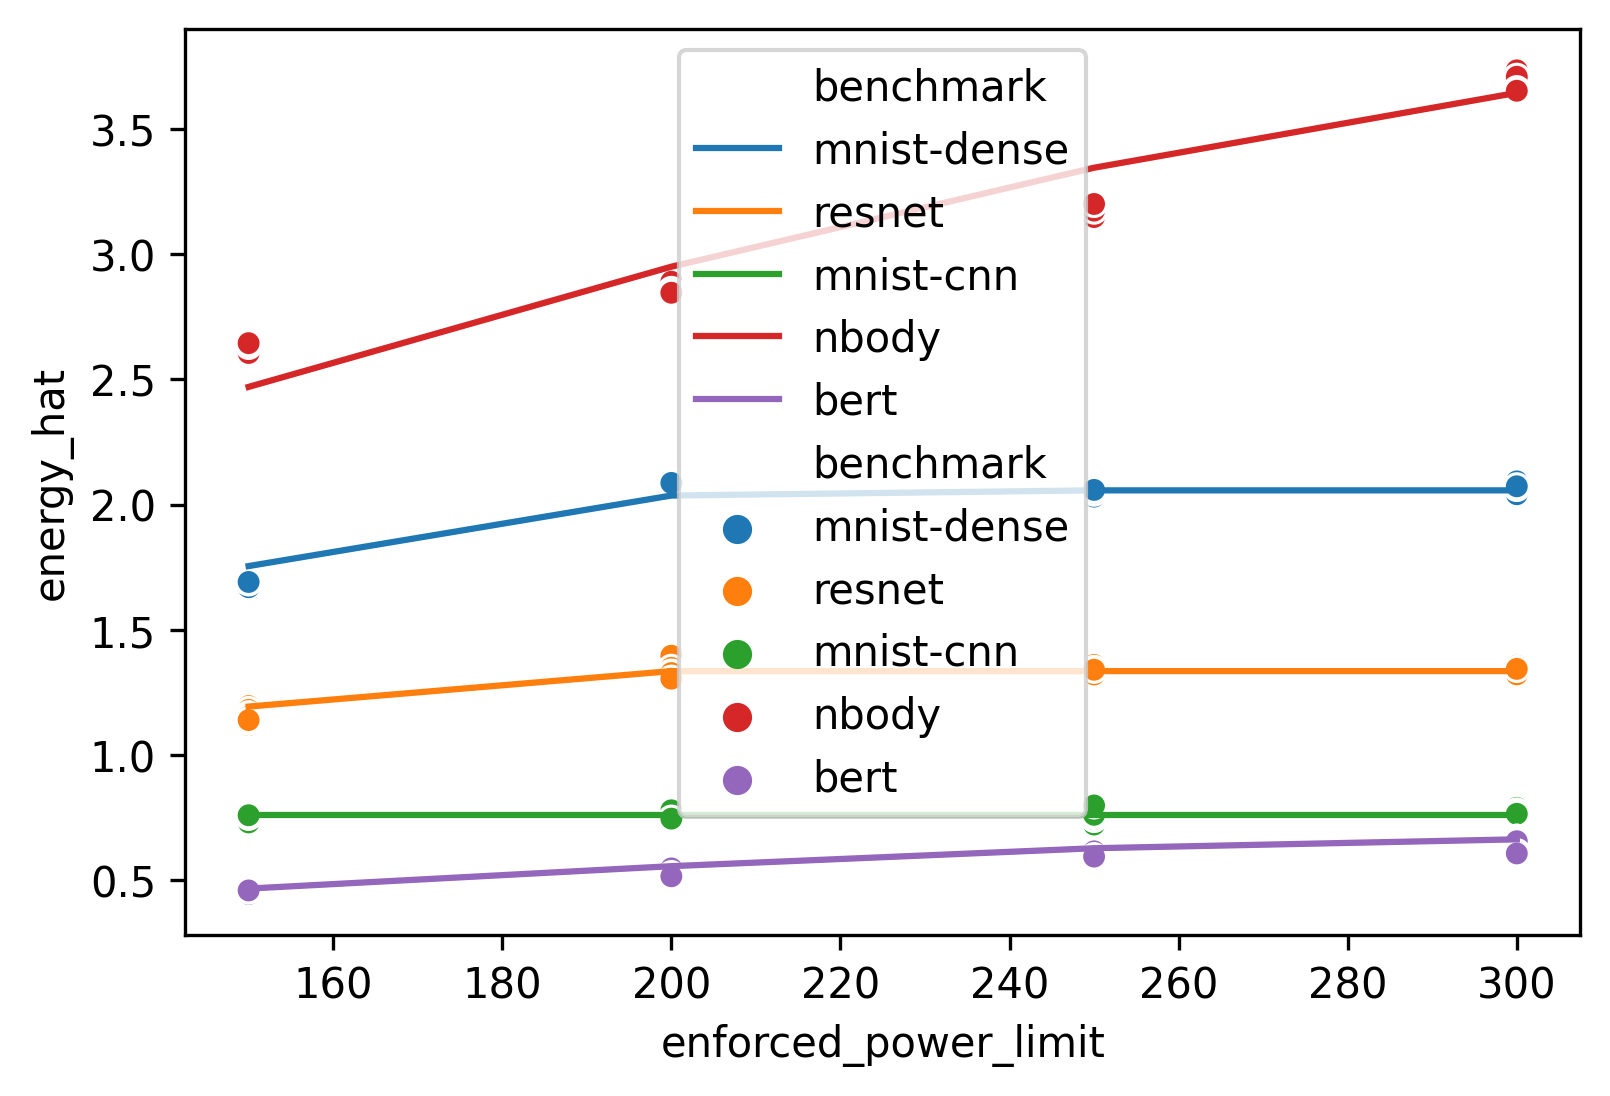

In [43]:
sns.scatterplot(x="enforced_power_limit",y="energy",hue="benchmark", data=all_agg)
#all_agg["clock_gpu_piecewise"] = np.interp(all_agg["enforced_power_limit"],all_agg["enforced_power_limit"], all_agg["clock_gpu"])
#sns.lineplot(x="enforced_power_limit",y="clock_gpu_piecewise",hue="benchmark", data=all_agg)
sns.lineplot(x="enforced_power_limit",y="energy_hat",hue="benchmark", data=all_agg)

In [154]:
#all_agg["clock3"] =  all_agg["clock_gpu"] ** 2# 1.8 #all_agg["p_util"] *
#all_agg["p1"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 3# 1.8 #all_agg["p_util"] *
#all_agg["p2"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 2
#all_agg["p3"] =  all_agg["p_util"] * all_agg["clock_gpu"]

In [155]:
#all_agg["clock3"] =  all_agg["clock_gpu"] ** 2# 1.8 #all_agg["p_util"] *
# 1.8 #all_agg["p_util"] *
all_agg["p1"] =  all_agg["p_util"] * all_agg["clock_gpu_hat"] ** 3
all_agg["p2"] =  all_agg["p_util"] * all_agg["clock_gpu_hat"] ** 2
all_agg["p3"] =  all_agg["p_util"] * all_agg["clock_gpu_hat"]

#all_agg["clock3"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 3 

#result = sm.ols(formula="power ~ clock3", data=all_agg#.groupby(["benchmark", "run"]).mean()
#               ).fit()


power_model = sm.ols(formula="power ~ p1 +p2 +p3", data=all_agg#[all_agg["benchmark"] != "resnet"]
            #.groupby(["benchmark", "run"]).mean()
               ).fit()
#result = sm.ols(formula="energy ~ clock3 + C(benchmark)", data=all_agg).fit()
#result = sm.ols(formula="energy ~  epl23 + C(benchmark)", data=all_agg).fit()

In [156]:
power_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     173.4
Date:                Wed, 10 Feb 2021   Prob (F-statistic):           6.66e-55
Time:                        00:46:02   Log-Likelihood:                -899.37
No. Observations:                 200   AIC:                             1807.
Df Residuals:                     196   BIC:                             1820.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.1750      6.528      6.767      0.000      31.301      57.049
p1         -1.682e-07   8.86e-08     -1.899      0.059   -3.43e-07    6.49e-09
p2             0.0005      0.000      2.125      0.035    3.67e-05       0.001
p3            -0.2448      0.161     -1.521      0.130      -0.562       0.073
==============================================================================
Omnibus:                       31.727   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.160
Skew:                          -0.997   Prob(JB):                     7.00e-10
Kurtosis:                       4.042   Cond. No.                     9.00e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  9e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
all_agg["pd1"] = 1 / all_agg["clock_gpu_hat"]
delay_model = sm.ols(formula="delay ~ pd1", data=all_agg#[all_agg["benchmark"] != "resnet"]
            #.groupby(["benchmark", "run"]).mean()
               ).fit()

In [158]:
delay_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delay   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     194.8
Date:                Wed, 10 Feb 2021   Prob (F-statistic):           2.82e-31
Time:                        00:46:03   Log-Likelihood:                 269.19
No. Observations:                 200   AIC:                            -534.4
Df Residuals:                     198   BIC:                            -527.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4902      0.040     12.198      0.000       0.411       0.569
pd1          791.1551     56.685     13.957      0.000     679.371     902.939
==============================================================================
Omnibus:                       25.419   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.924
Skew:                           0.895   Prob(JB):                     1.93e-07
Kurtosis:                       3.710   Cond. No.                     1.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [159]:
# all_agg["p1"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 3# 1.8 #all_agg["p_util"] *
# all_agg["p2"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 2
# all_agg["p3"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 1
# result = sm.ols(formula="energy ~ p1 +p2 +p3", data=all_agg#[all_agg["benchmark"] != "resnet"]
#             #.groupby(["benchmark", "run"]).mean()
#                ).fit()

In [160]:
def predict_n_residuals(df, column: str, model):
    df[f"{column}_hat"] =  model.predict(df)
    df[f"{column}_res"] = df[f"{column}_hat"] - df[str(column)]

In [53]:
predict_n_residuals(all_agg, "power", power_model)

In [54]:
predict_n_residuals(all_agg, "delay", delay_model)

In [123]:
predict_n_residuals(all_agg, "clock_gpu", clock_model)

In [55]:
all_agg["time_hat"] =  all_agg["time_ref"] * all_agg["delay_hat"]

In [56]:
all_agg["energy_hat"] = (all_agg["power_hat"] * all_agg["time_hat"]) / 1_000

<AxesSubplot:xlabel='energy', ylabel='energy_hat'>

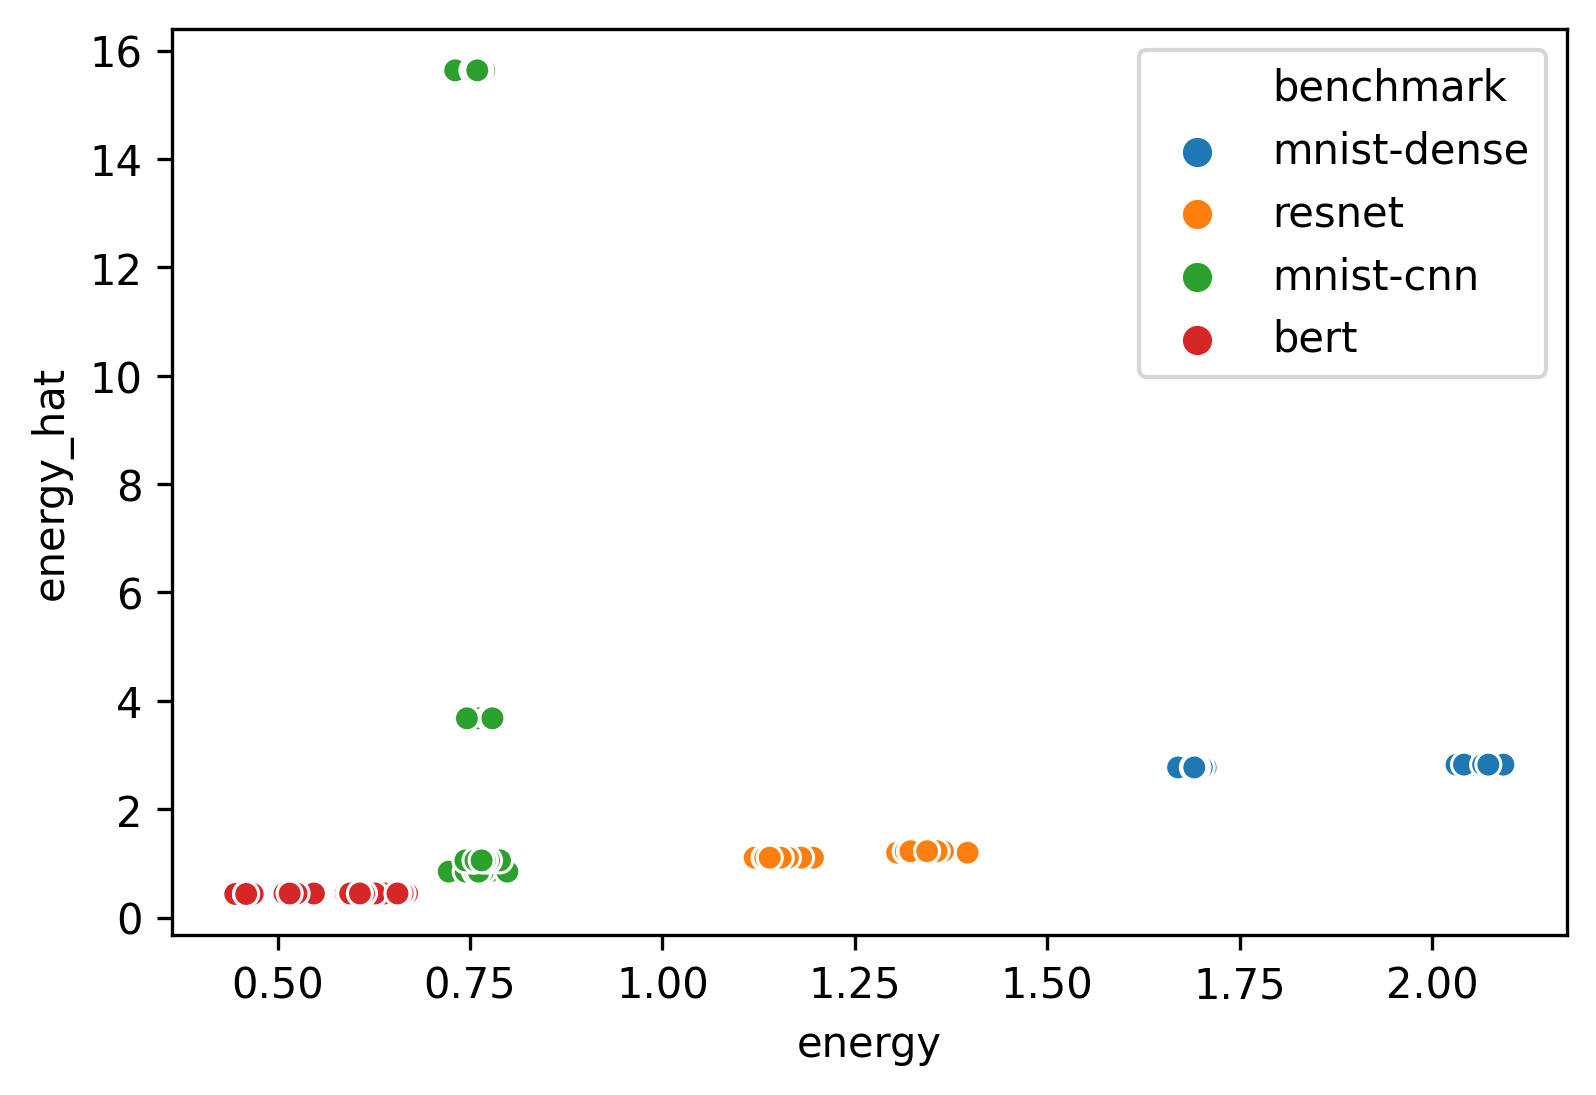

In [91]:
sns.scatterplot(x="energy",y="energy_hat",hue="benchmark", data=all_agg)

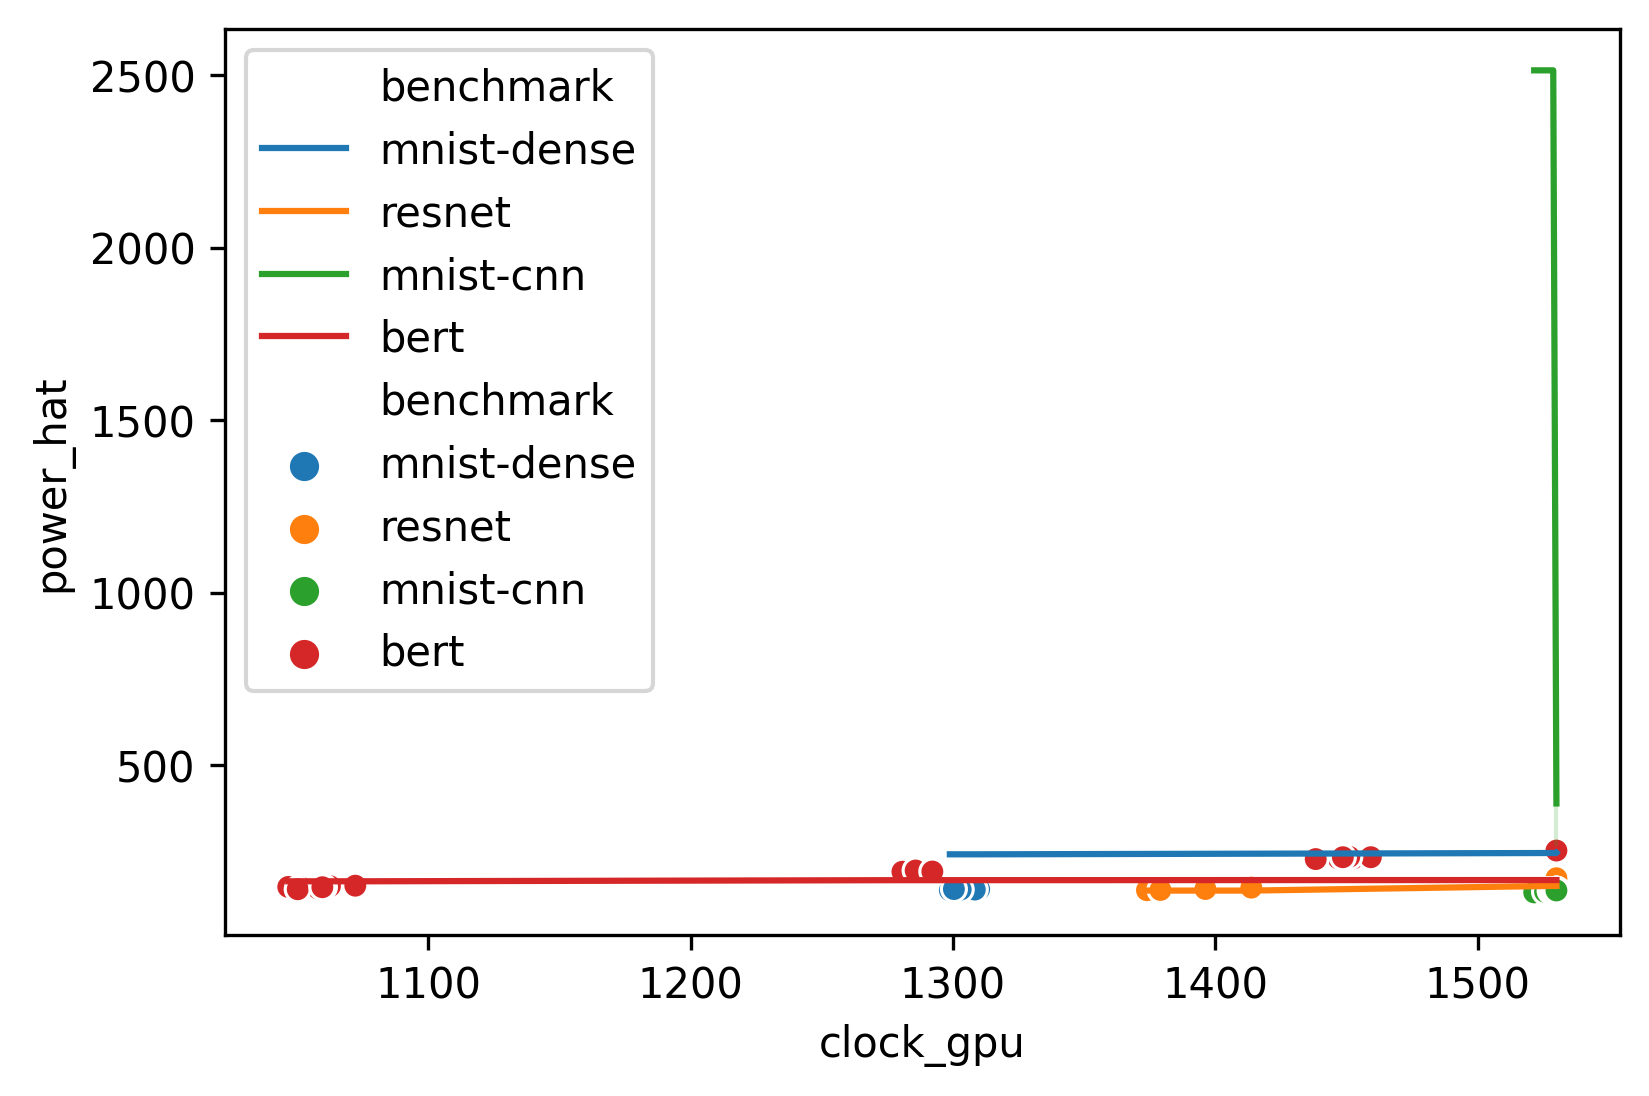

In [93]:
#sns.scatterplot(x="clock_gpu",y="power",hue="benchmark", data=all_agg)
#    sns.lineplot(x="clock_gpu",y="e_hat",hue="benchmark", data=all_agg)#, style=list("xxxxxxxxxxxxxxx"), markers={"x":"x"})
plot_model("clock_gpu", "power", all_agg)

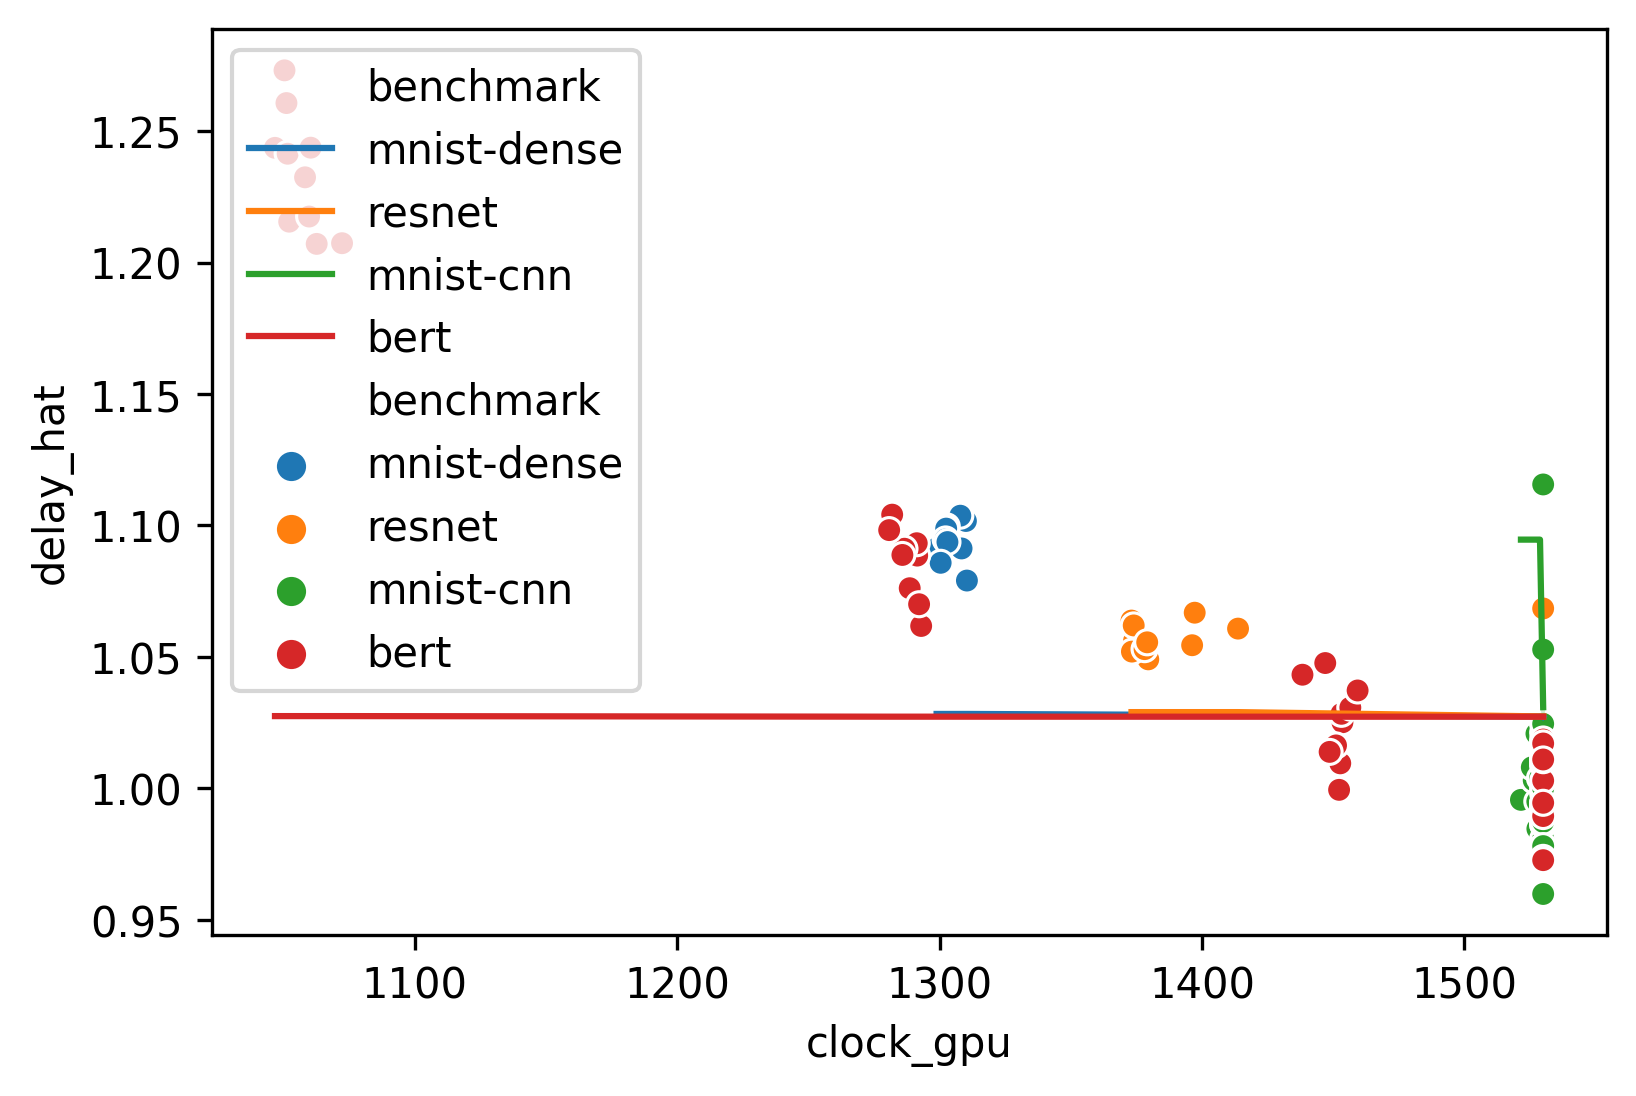

In [94]:
plot_model(x="clock_gpu", y="delay", data=all_agg)

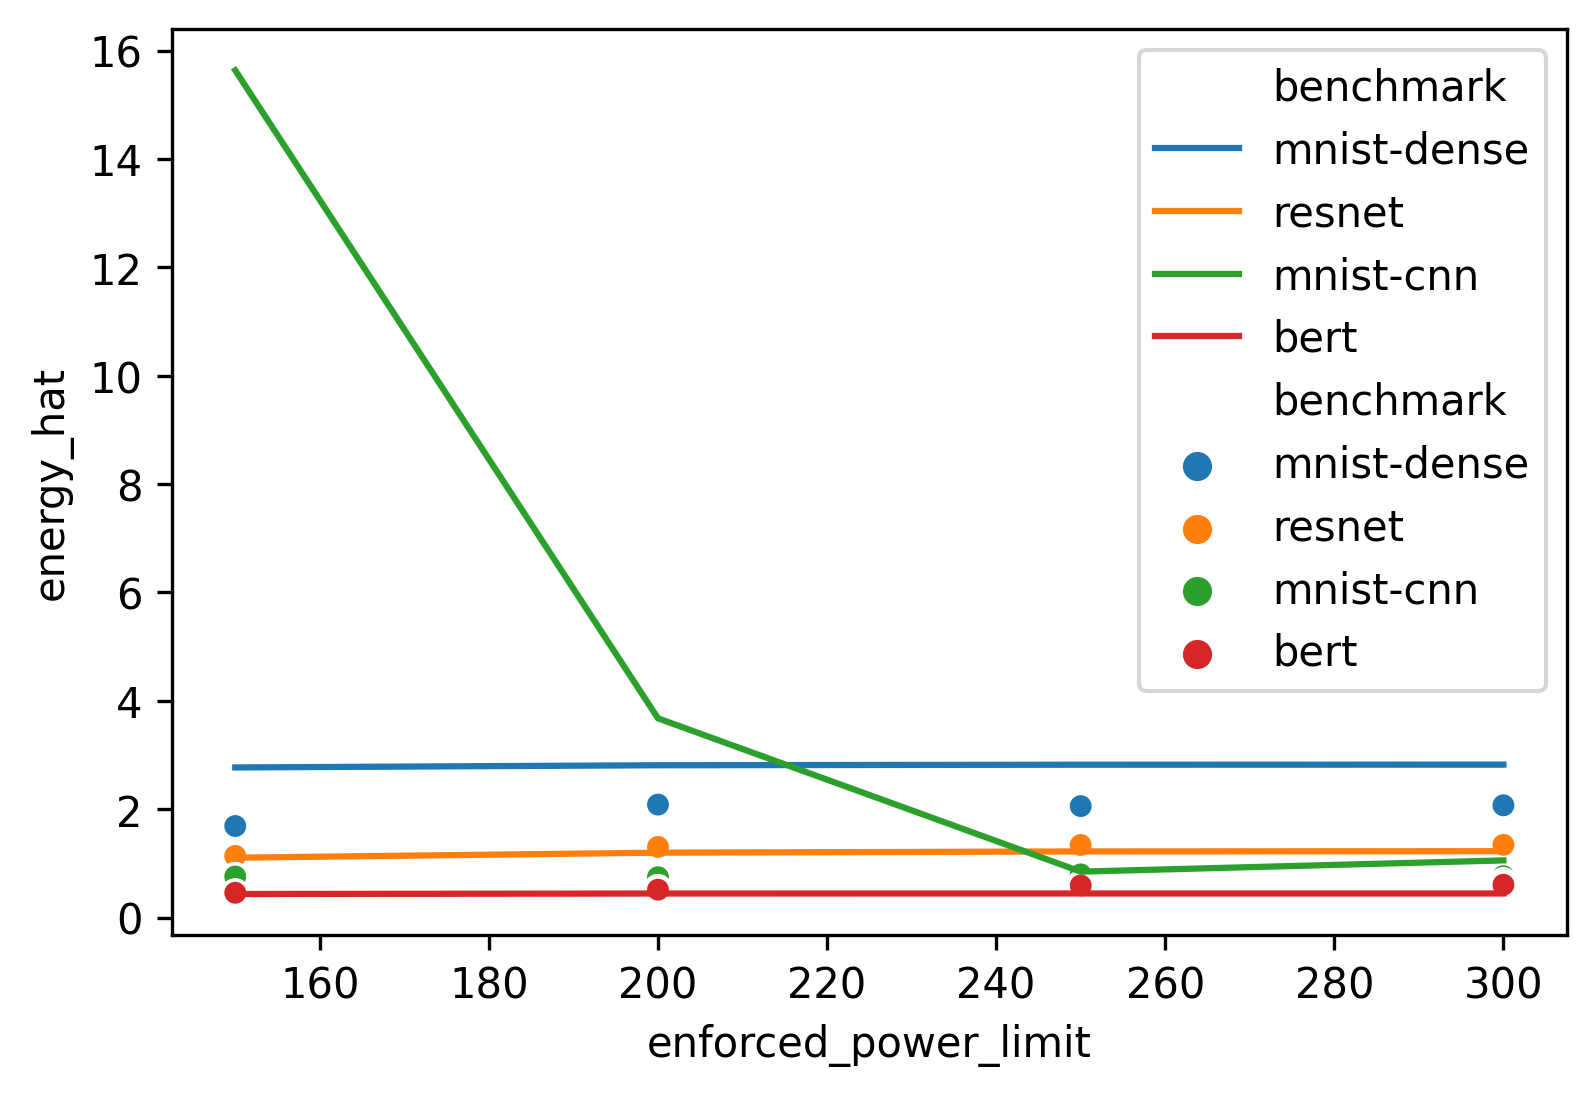

In [95]:
plot_model(x="enforced_power_limit", y="energy", data=all_agg)